# Telecom Churn Case Study

Submitted by
- Mansi Gupta
- Parijaat Sunil
- Venkata Rama Krishna Kuruva

## 1. Initializing Python Libraries

In [315]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# importing machine learning libraries and methods
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE, RFECV
from sklearn.decomposition import PCA, IncrementalPCA

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, classification_report

In [2]:
# Setting pandas to display maximum number of columns
pd.set_option('display.max_columns', None)

## 2. Importing and analyzing the dataframe

In [3]:
# Importing the Telecom Churn data file into a pandas dataframe
data = pd.read_csv("telecom_churn_data.csv")


In [4]:
# Checking the top 5 rows of the dataframe
data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [5]:
# Checking the shape of the dataframe
data.shape

(99999, 226)

In [6]:
# Checking info of the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


Inferences:
- There are a 226 columns and 99999 rows in the data

## 3. Cleaning the dataframe

### a. Dropping columns with unique identifiers and single values

In [7]:
# Creating a list of all columns with unique identifiers and single values in the dataframe
uniq_cols = [x for x in data.columns if data[x].nunique() in (99999,1)]
uniq_cols

['mobile_number',
 'circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_date_of_month_9',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_og_t2c_mou_9',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8',
 'std_ic_t2o_mou_9']

In [8]:
# Dropping the columsn in the above list
data.drop(uniq_cols, axis =1, inplace=True)
data.shape

(99999, 209)

The columns with unique and single values have been dropped

### b. Dropping columns with a high number of missing values

In [9]:
# Finding the percentage of missing data in the dataframe
null_p = data.isnull().sum() / len(data) * 100
null_p

arpu_6         0.000000
arpu_7         0.000000
arpu_8         0.000000
arpu_9         0.000000
onnet_mou_6    3.937039
                 ...   
aon            0.000000
aug_vbc_3g     0.000000
jul_vbc_3g     0.000000
jun_vbc_3g     0.000000
sep_vbc_3g     0.000000
Length: 209, dtype: float64

We can drop columns with more than 40% missing data

In [10]:
# Finding columns with more than 40% missin data
drop_null_p = null_p[null_p>40]
drop_null_p

date_of_last_rech_data_6    74.846748
date_of_last_rech_data_7    74.428744
date_of_last_rech_data_8    73.660737
date_of_last_rech_data_9    74.077741
total_rech_data_6           74.846748
total_rech_data_7           74.428744
total_rech_data_8           73.660737
total_rech_data_9           74.077741
max_rech_data_6             74.846748
max_rech_data_7             74.428744
max_rech_data_8             73.660737
max_rech_data_9             74.077741
count_rech_2g_6             74.846748
count_rech_2g_7             74.428744
count_rech_2g_8             73.660737
count_rech_2g_9             74.077741
count_rech_3g_6             74.846748
count_rech_3g_7             74.428744
count_rech_3g_8             73.660737
count_rech_3g_9             74.077741
av_rech_amt_data_6          74.846748
av_rech_amt_data_7          74.428744
av_rech_amt_data_8          73.660737
av_rech_amt_data_9          74.077741
arpu_3g_6                   74.846748
arpu_3g_7                   74.428744
arpu_3g_8   

In [11]:
# Finding the total number of columns with more than 40% missing data
len(drop_null_p)

40

We see a total of 40 columns having more than 40% missing data. We can drop these columns from our dataframe.

In [12]:
# Dropping columns with more than 40% missing data
data.drop(drop_null_p.index, axis = 1, inplace = True)

In [13]:
# Checking the info of the dataframe after dropping columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 169 entries, arpu_6 to sep_vbc_3g
dtypes: float64(132), int64(33), object(4)
memory usage: 128.9+ MB


In [14]:
# Checking the remaining columns
data.head()

,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,2,6,362,252,252,0,252,252,252,0,6/21/2014,7/16/2014,8/8/2014,9/28/2014,252,252,252,0,30.13,1.32,5.75,0.0,83.57,150.76,109.61,0.00,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,968,30.4,0.0,101.20,3.58
1,34.047,355.074,268.321,86.285,24.11,78.68,7.68,18.34,15.74,99.84,304.76,53.76,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,23.88,74.56,7.68,18.34,11.51,75.94,291.86,53.76,0.00,0.00,0.00,0.00,0.0,2.91,0.00,0.00,35.39,150.51,299.54,72.11,0.23,4.11,0.00,0.00,0.00,0.46,0.13,0.00,0.00,0.00,0.00,0.0,0.23,4.58,0.13,0.00,0.0,0.0,0.0,0.0,4.68,23.43,12.76,0.00,0.00,0.0,0.0,0.0,40.31,178.53,312.44,72.11,1.61,29.91,29.23,116.09,17.48,65.38,375.58,56.93,0.00,8.93,3.61,0.00,19.09,104.23,408.43,173.03,0.00,0.00,2.35,0.00,5.90,0.00,12.49,15.01,0.00,0.00,0.00,0.00,5.90,0.00,14.84,15.01,26.83,104.23,423.28,188.04,0.00,0.0,0.0,0.00,1.83,0.00,0.0,0.00,0.00,0.00,0.0,0.00,4,9,11,5,74,384,283,121,44,154,65,50,6/29/2014,7/31/2014,8/28/2014,9/30/2014,44,23,30,0,0.00,108.07,365.47,0.0,0.00,0.00,0.00,0.00,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1006,0.0,0.0

### c. Handling columns with date values

We can drop columns with date values as we will capture churn based on already available columns from September month data

In [15]:
# Finding all columns with data data
date_col = [col for col in data.columns if 'date' in col]
date_col

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9']

In [16]:
# Dropping all columns containing date values
data.drop(date_col, axis = 1, inplace = True)
data.shape

(99999, 165)

### d. Dropping all rows with duplicate data

In [17]:
# Dropping rows with duplicate data
data.drop_duplicates()
data.shape

(99999, 165)

There were no duplicate rows in the data

### e. Finding the high value customers and dropping other rows

As per problem statement, the high value customers are defined as the top 70 percentile of customers by recharge amounts in June and July months

In [18]:
# Creating a new column to find mean of recharge amounts in June and July
data['total_rchg_6_7'] = (data['total_rech_amt_6'] + data['total_rech_amt_7'])/2
data['total_rchg_6_7']

0        307.0
1        229.0
2        241.5
3        270.0
4        273.0
         ...  
99994     85.0
99995    110.0
99996     59.5
99997    369.5
99998    355.0
Name: total_rchg_6_7, Length: 99999, dtype: float64

In [19]:
# Calculating the 70th percentile of this newly added column
percentile_70 = np.percentile(data['total_rchg_6_7'],70)
percentile_70

368.5

In [20]:
# Finding the high value customers
data['high_value_customer'] = data['total_rchg_6_7'][data['total_rchg_6_7'] >= percentile_70]
data['high_value_customer'].unique()

array([   nan, 1185. ,  519. , ..., 3925. , 2915.5, 1878. ])

In [21]:
# Finding the subset of non null values from high_value_customer column
data_df = data.dropna(subset = ['high_value_customer'])
data_df.shape

(30011, 167)

In [22]:
# Dropping the created column for recharge amount in June and July
data_df.drop('total_rchg_6_7', axis = 1, inplace = True)
data_df.drop('high_value_customer', axis = 1, inplace = True)

In [23]:
data_df.shape

(30011, 165)

We now have our dataset with high value customers only

### f. Creating the churn column and dropping columns for September

In [24]:
# Creating a custom function to check if incoming or outgoing for September is 0
def compare_for_churn(df):
    if (df['total_og_mou_9'] == 0 and df['total_ic_mou_9'] == 0) and (df['vol_2g_mb_9']==0 and df['vol_3g_mb_9']==0):
        return 1
    else:
        return 0

# Applying the function to our dataframe
data_df['churn'] = data_df.apply(compare_for_churn, axis = 1)
data_df.head()

,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn
7,1069.180,1349.850,3171.480,500.000,57.84,54.68,52.29,NaN,453.43,567.16,325.91,NaN,16.23,33.49,31.64,NaN,23.74,12.59,38.06,NaN,51.39,31.38,40.28,NaN,308.63,447.38,162.28,NaN,62.13,55.14,53.23,NaN,0.0,0.0,0.00,NaN,422.16,533.91,255.79,NaN,4.30,23.29,12.01,NaN,49.89,31.76,49.14,NaN,6.66,20.08,16.68,NaN,60.86,75.14,77.84,NaN,0.0,0.18,10.01,NaN,4.50,0.00,6.50,NaN,0.00,0.0,0.0,NaN,487.53,609.24,350.16,0.00,58.14,32.26,27.31,NaN,217.56,221.49,121.19,NaN,152.16,101.46,39.53,NaN,427.88,355.23,188.04,NaN,36.89,11.83,30.39,NaN,91.44,126.99,141.33,NaN,52.19,34.24,22.21,NaN,180.54,173.08,193.94,NaN,626.46,558.04,428.74,0.00,0.21,0.0,0.0,NaN,2.06,14.53,31.59,NaN,15.74,15.19,15.14,NaN,5,5,7,3,1580,790,3638,0,1580,790,1580,0,0,0,779,0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,0.0,1
8,378.721,492.223,137.362,166.787,413.69,351.03,35.08,33.46,94.66,80.63,136.48,108.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,26.13,80.96,70.58,50.54,34.58,0.00,0.00,0.00,0.00,0.0,0.0,7.15,0.0,378.09,288.18,63.04,60.71,116.56,133.43,22.58,7.33,13.69,10.04,75.69,74.13,0.00,0.00,0.00,0.00,130.26,143.48,98.28,81.46,0.0,0.00,0.00,0.0,0.00,0.00,10.23,0.00,0.00,0.0,0.0,0.0,508.36,431.66,171.56,142.18,23.84,9.84,0.31,4.03,57.58,13.98,15.48,17.34,0.00,0.00,0.00,0.00,81.43,23.83,15.79,21.38,0.00,0.58,0.10,0.00,22.43,4.08,0.65,13.53,0.00,0.00,0.00,0.0,22.43,4.66,0.75,13.53,103.86,28.49,16.54,34.91,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,15,437,601,120,186,90,154,30,36,50,0,10,0,0.0,356.0,0.03,0.0,0.0,750.95,11.94,0.0,0,1,0,0,0,1,3,0,0,0,0,0,0,0,0,0,

In [25]:
# Creating a list of all columns with data for September
col_9 = [col for col in data_df.columns if ('_9' in col) or ('sep' in col)]
col_9

['arpu_9',
 'onnet_mou_9',
 'offnet_mou_9',
 'roam_ic_mou_9',
 'roam_og_mou_9',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_9',
 'loc_og_mou_9',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_9',
 'std_og_mou_9',
 'isd_og_mou_9',
 'spl_og_mou_9',
 'og_others_9',
 'total_og_mou_9',
 'loc_ic_t2t_mou_9',
 'loc_ic_t2m_mou_9',
 'loc_ic_t2f_mou_9',
 'loc_ic_mou_9',
 'std_ic_t2t_mou_9',
 'std_ic_t2m_mou_9',
 'std_ic_t2f_mou_9',
 'std_ic_mou_9',
 'total_ic_mou_9',
 'spl_ic_mou_9',
 'isd_ic_mou_9',
 'ic_others_9',
 'total_rech_num_9',
 'total_rech_amt_9',
 'max_rech_amt_9',
 'last_day_rch_amt_9',
 'vol_2g_mb_9',
 'vol_3g_mb_9',
 'monthly_2g_9',
 'sachet_2g_9',
 'monthly_3g_9',
 'sachet_3g_9',
 'sep_vbc_3g']

In [26]:
# Dropping all columns with data from September
data_df.drop(col_9, axis=1, inplace=True)

In [27]:
data_df.shape

(30011, 125)

In [28]:
# Checking the data imbalance
data_df['churn'].value_counts(normalize = True)*100

churn
0    91.359835
1     8.640165
Name: proportion, dtype: float64

There is a large data imbalance in the dataset with only 8.6% of customers who have churned. We need to handle this imbalance

### g. Assessing other columns with missing values

In [29]:
# Checking the null percentage for columns with any missing values
null_p = data_df.isnull().sum() / len(data) * 100
null_p[null_p>0].sort_values(ascending=False)

ic_others_8         0.938009
loc_og_t2m_mou_8    0.938009
std_og_mou_8        0.938009
spl_og_mou_8        0.938009
std_og_t2f_mou_8    0.938009
                      ...   
std_og_t2f_mou_7    0.303003
og_others_7         0.303003
std_og_mou_7        0.303003
spl_og_mou_7        0.303003
isd_og_mou_7        0.303003
Length: 81, dtype: float64

In [30]:
# Checking the null values where churn is 1
null_ch = data_df[data_df.churn==1].isnull().sum() / len(data) * 100
null_ch[null_ch>0].sort_values(ascending=False)

ic_others_8         0.736007
loc_og_t2m_mou_8    0.736007
std_og_mou_8        0.736007
spl_og_mou_8        0.736007
std_og_t2f_mou_8    0.736007
                      ...   
loc_ic_t2t_mou_6    0.106001
std_og_mou_6        0.106001
og_others_6         0.106001
isd_og_mou_6        0.106001
onnet_mou_6         0.106001
Length: 81, dtype: float64

As we cannot lose any columns with churn as 1, we can fill the above missing values by 0

In [31]:
# Filling all missing values with 0 where churn is 1

data_df.loc[data_df.churn==1,:]=data_df.loc[data_df.churn==1,:].fillna(0)

# Checking the null values where churn is 1 again
null_ch = data_df[data_df.churn==1].isnull().sum() / len(data) * 100
null_ch[null_ch>0].sort_values(ascending=False)

Series([], dtype: float64)

In [32]:
# Checking the null percentage for columns with any missing values again
null_p = data_df.isnull().sum() / len(data) * 100
null_p[null_p>0].sort_values(ascending=False)

onnet_mou_6         0.210002
std_ic_t2m_mou_6    0.210002
spl_og_mou_6        0.210002
std_og_mou_6        0.210002
og_others_6         0.210002
                      ...   
std_og_t2f_mou_7    0.144001
og_others_7         0.144001
std_og_mou_7        0.144001
spl_og_mou_7        0.144001
isd_og_mou_7        0.144001
Length: 81, dtype: float64

We can drop these rows as they are a very small fraction of the data, and this will also reduce imbalance

In [33]:
# Droppng remaining rows with missing values
data_df.dropna(inplace=True)

In [34]:
# Checking the null percentage for columns with any missing values again
null_p = data_df.isnull().sum() / len(data) * 100
null_p[null_p>0].sort_values(ascending=False)

Series([], dtype: float64)

In [35]:
data_df.shape

(29647, 125)

In [36]:
# Checking the data imbalance again
data_df['churn'].value_counts(normalize = True)*100

churn
0    91.253752
1     8.746248
Name: proportion, dtype: float64

### h. Dropping total columns for incoming, outgoing

If we analyze the data, we see that the total columns for example loc_og_mou, std_og_mou, total_og_mou, loc_ic_mou_6 etc. are not always correct. There are several places where the sum is wrong. We can drop these columns and create new total columns as derived variables


In [37]:
# Creating a list of all columns with total values
total_cols = ['loc_og_mou_6','loc_og_mou_7','loc_og_mou_8','std_og_mou_6','std_og_mou_7','std_og_mou_8','total_og_mou_6','total_og_mou_7',
             'total_og_mou_8','loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8','std_ic_mou_6','std_ic_mou_7','std_ic_mou_8','total_ic_mou_6',
             'total_ic_mou_7','total_ic_mou_8','onnet_mou_6','onnet_mou_7','onnet_mou_8','offnet_mou_6','offnet_mou_7','offnet_mou_8']

# Dropping the above columns
data_df.drop(total_cols, axis=1, inplace=True)
data_df.shape

(29647, 101)

In [38]:
data_df.head()

,arpu_6,arpu_7,arpu_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn
7,1069.180,1349.850,3171.480,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.18,10.01,4.50,0.00,6.50,0.00,0.0,0.0,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,0,0,779,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,1
8,378.721,492.223,137.362,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,10.23,0.00,0.0,0.0,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,50,0,10,0.0,356.0,0.03,0.0,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0
13,492.846,205.671,593.260,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.0,0.0,0.49,446.41,85.98,498.23,255.36,52.94,156.94,0.00,0.00,0.00,0.0,0.00,1.29,0.00,0.00,4.78,0.00,0.0,0.0,67.88,7.58,52.58,142.88,18.53,195.18,4.81,0.00,7.49,115.68,38.29,154.58,308.13,29.79,317.91,0.00,0.00,1.91,0.45,0.0,0.0,245.28,62.11,393.39,83.48,16.24,21.44,6,4,11,507,253,717,110,110,130,110,50,0,0.0,0.0,0.02,0.0,0.00,0.00,0,0,0,0,0,3,0,0,0,0,0,0,2607,0.00,0.00,0.00,0
16,430.975,299.869,187.894,0.00,2.83,0.00,0.00,17.74,0.00,42.61,65.16,67.38,273.29,145.99,128.28,0.00,4.48,10.26,0.0,0.0,0.00,7.89,2.58,3.23,22.99,64.51,18.29,0.00,0.00,0.00,0.0,0.00,0.00,0.00,3.26,5.91,0.00,0.0,0.0,41.33,71.44,28.89,226.81,149.69,150.16,8.71,8.68,32.71,68.79,78.64,6.33,18.68,73.08,73.93,0.51,0.00,2.18,0.00,0.0,0.0,0.00,0.00,0.23,0.00,0.00,0.00,10,6,2,570,348,160,110,110,130,100,100,130,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,511,0.00,2.45,21.89,0
17,690.008,18.980,25.499,0.00,4.76,4.81,0.00,8.46,13.34,38.99,0.00,0.00,58.54,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1146.91,0.81,0.00,1.55,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,2.58,0.00,0.00,0.93,0.0,0.0,34.54,0.00,0.00,47.41,2.31,0.00,0.00,0.00,0.00,8.63,0.00,0.00,1.28,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,2,4,816,0,30,110,0,30,30,0,0,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,667,0.00,0.00,0.00,0


## 4. Creating derived variables

We can now create the total rows for incoming and outgoing MOU categories. We will keep the T2C columns without adding them to the total rows as we expect to see higher calls to call centres in case of churn.

### a. Outgoing MOU for each month

In [39]:
# Creating a list of all columns to be added for each month except T2C Columns
og_mou_6 = ['loc_og_t2t_mou_6','loc_og_t2m_mou_6','loc_og_t2f_mou_6','std_og_t2t_mou_6','std_og_t2m_mou_6','std_og_t2f_mou_6','isd_og_mou_6',
            'spl_og_mou_6','og_others_6']

og_mou_7 = ['loc_og_t2t_mou_7','loc_og_t2m_mou_7','loc_og_t2f_mou_7','std_og_t2t_mou_7','std_og_t2m_mou_7','std_og_t2f_mou_7','isd_og_mou_7',
            'spl_og_mou_7','og_others_7']

og_mou_8 = ['loc_og_t2t_mou_8','loc_og_t2m_mou_8','loc_og_t2f_mou_8','std_og_t2t_mou_8','std_og_t2m_mou_8','std_og_t2f_mou_8','isd_og_mou_8',
            'spl_og_mou_8','og_others_8']

# Creating a new sum columns for each month
data_df['total_og_mou_6']=data_df[og_mou_6].sum(axis=1)
data_df['total_og_mou_7']=data_df[og_mou_7].sum(axis=1)
data_df['total_og_mou_8']=data_df[og_mou_8].sum(axis=1)
data_df.head()

,arpu_6,arpu_7,arpu_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn,total_og_mou_6,total_og_mou_7,total_og_mou_8
7,1069.180,1349.850,3171.480,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.18,10.01,4.50,0.00,6.50,0.00,0.0,0.0,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,0,0,779,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,1,487.50,609.21,350.13
8,378.721,492.223,137.362,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,10.23,0.00,0.0,0.0,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,50,0,10,0.0,356.0,0.03,0.0,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0,508.34,431.64,171.53
13,492.846,205.671,593.260,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.0,0.0,0.49,446.41,85.98,498.23,255.36,52.94,156.94,0.00,0.00,0.00,0.0,0.00,1.29,0.00,0.00,4.78,0.00,0.0,0.0,67.88,7.58,52.58,142.88,18.53,195.18,4.81,0.00,7.49,115.68,38.29,154.58,308.13,29.79,317.91,0.00,0.00,1.91,0.45,0.0,0.0,245.28,62.11,393.39,83.48,16.24,21.44,6,4,11,507,253,717,110,110,130,110,50,0,0.0,0.0,0.02,0.0,0.00,0.00,0,0,0,0,0,3,0,0,0,0,0,0,2607,0.00,0.00,0.00,0,907.07,192.39,1015.22
16,430.975,299.869,187.894,0.00,2.83,0.00,0.00,17.74,0.00,42.61,65.16,67.38,273.29,145.99,128.28,0.00,4.48,10.26,0.0,0.0,0.00,7.89,2.58,3.23,22.99,64.51,18.29,0.00,0.00,0.00,0.0,0.00,0.00,0.00,3.26,5.91,0.00,0.0,0.0,41.33,71.44,28.89,226.81,149.69,150.16,8.71,8.68,32.71,68.79,78.64,6.33,18.68,73.08,73.93,0.51,0.00,2.18,0.00,0.0,0.0,0.00,0.00,0.23,0.00,0.00,0.00,10,6,2,570,348,160,110,110,130,100,100,130,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,511,0.00,2.45,21.89,0,346.78,285.98,233.35
17,690.008,18.980,25.499,0.00,4.76,4.81,0.00,8.46,13.34,38.99,0.00,0.00,58.54,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1146.91,0.81,0.00,1.55,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,2.58,0.00,0.00,0.93,0.0,0.0,34.54,0.00,0.00,47.41,2.31,0.00,0.00,0.00,0.00,8.63,0.00,0.00,1.28,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,2,4,816,0,30,110,0,30,30,0,0,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,667,0.00,0.00,0.0

In [40]:
# Dropping the outgoing columns
data_df.drop(og_mou_6, axis=1, inplace=True)
data_df.drop(og_mou_7, axis=1, inplace=True)
data_df.drop(og_mou_8, axis=1, inplace=True)
data_df.shape

(29647, 77)

### b. Incoming MOU for each month

In [41]:
# Creating a list of all columns to be added for each month
ic_mou_6 = ['loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6','spl_ic_mou_6',
            'isd_ic_mou_6','ic_others_6']

ic_mou_7 = ['loc_ic_t2t_mou_7','loc_ic_t2m_mou_7','loc_ic_t2f_mou_7','std_ic_t2t_mou_7','std_ic_t2m_mou_7','std_ic_t2f_mou_7','spl_ic_mou_7',
            'isd_ic_mou_7','ic_others_7']

ic_mou_8 = ['loc_ic_t2t_mou_8','loc_ic_t2m_mou_8','loc_ic_t2f_mou_8','std_ic_t2t_mou_8','std_ic_t2m_mou_8','std_ic_t2f_mou_8','spl_ic_mou_8',
            'isd_ic_mou_8','ic_others_8']

# Creating a new sum columns for each month
data_df['total_ic_mou_6']=data_df[ic_mou_6].sum(axis=1)
data_df['total_ic_mou_7']=data_df[ic_mou_7].sum(axis=1)
data_df['total_ic_mou_8']=data_df[ic_mou_8].sum(axis=1)
data_df.head()

,arpu_6,arpu_7,arpu_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8
7,1069.180,1349.850,3171.480,16.23,33.49,31.64,23.74,12.59,38.06,0.0,0.0,0.00,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,0,0,779,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,1,487.50,609.21,350.13,626.39,557.99,428.69
8,378.721,492.223,137.362,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,7.15,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,50,0,10,0.0,356.0,0.03,0.0,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0,508.34,431.64,171.53,103.85,28.48,16.54
13,492.846,205.671,593.260,23.53,144.24,72.11,7.98,35.26,1.44,0.0,0.0,0.49,67.88,7.58,52.58,142.88,18.53,195.18,4.81,0.00,7.49,115.68,38.29,154.58,308.13,29.79,317.91,0.00,0.00,1.91,0.45,0.0,0.0,245.28,62.11,393.39,83.48,16.24,21.44,6,4,11,507,253,717,110,110,130,110,50,0,0.0,0.0,0.02,0.0,0.00,0.00,0,0,0,0,0,3,0,0,0,0,0,0,2607,0.00,0.00,0.00,0,907.07,192.39,1015.22,968.59,172.54,1144.48
16,430.975,299.869,187.894,0.00,2.83,0.00,0.00,17.74,0.00,0.0,0.0,0.00,41.33,71.44,28.89,226.81,149.69,150.16,8.71,8.68,32.71,68.79,78.64,6.33,18.68,73.08,73.93,0.51,0.00,2.18,0.00,0.0,0.0,0.00,0.00,0.23,0.00,0.00,0.00,10,6,2,570,348,160,110,110,130,100,100,130,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,511,0.00,2.45,21.89,0,346.78,285.98,233.35,364.83,381.53,294.43
17,690.008,18.980,25.499,0.00,4.76,4.81,0.00,8.46,13.34,0.0,0.0,0.00,34.54,0.00,0.00,47.41,2.31,0.00,0.00,0.00,0.00,8.63,0.00,0.00,1.28,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,2,4,816,0,30,110,0,30,30,0,0,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,667,0.00,0.00,0.00,0,1249.50,0.81,0.00,91.86,2.31,0.00


In [42]:
# Dropping the outgoing columns
data_df.drop(ic_mou_6, axis=1, inplace=True)
data_df.drop(ic_mou_7, axis=1, inplace=True)
data_df.drop(ic_mou_8, axis=1, inplace=True)
data_df.shape

(29647, 53)

### c. Creating combined data columns

In [43]:
# Adding the respective variables for 2G and 3G columns
data_df['data_6']=data_df.vol_2g_mb_6 + data_df.vol_3g_mb_6
data_df['data_7']=data_df.vol_2g_mb_7 + data_df.vol_3g_mb_7
data_df['data_8']=data_df.vol_2g_mb_8 + data_df.vol_3g_mb_8
data_df['monthly_6']=data_df.monthly_2g_6 + data_df.monthly_3g_6
data_df['monthly_7']=data_df.monthly_2g_7 + data_df.monthly_3g_7
data_df['monthly_8']=data_df.monthly_2g_8 + data_df.monthly_3g_8
data_df['sachet_6']=data_df.sachet_2g_6 + data_df.sachet_3g_6
data_df['sachet_7']=data_df.sachet_2g_7 + data_df.sachet_3g_7
data_df['sachet_8']=data_df.sachet_2g_8 + data_df.sachet_3g_8

# Dropping the 2G & 3G columns
data_df.drop(['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8','monthly_2g_6','monthly_2g_7',
              'monthly_2g_8','monthly_3g_6','monthly_3g_7','monthly_3g_8','sachet_2g_6','sachet_2g_7','sachet_2g_8','sachet_3g_6',
              'sachet_3g_7','sachet_3g_8'], axis=1, inplace=True)

In [44]:
data_df.shape

(29647, 44)

### d. Creating variables to store the average values of good phase (June and July)

In [45]:
# creating column to store average arpu for 6 & 7 and dropping individual cols
data_df['arpu_avg_good'] = (data_df.arpu_6 + data_df.arpu_7)/2
data_df.drop(['arpu_6','arpu_7'], axis=1, inplace=True)

# creating column to store average roaming mou for 6 & 7 and dropping individual cols
data_df['roam_ic_avg_good'] = (data_df.roam_ic_mou_6 + data_df.roam_ic_mou_7)/2
data_df['roam_og_avg_good'] = (data_df.roam_og_mou_6 + data_df.roam_og_mou_7)/2
data_df.drop(['roam_og_mou_6','roam_og_mou_7','roam_ic_mou_6','roam_ic_mou_7'], axis=1, inplace=True)

# creating column to store average T2C mou for 6 & 7 and dropping individual cols
data_df['T2C_avg_good'] = (data_df.loc_og_t2c_mou_6 + data_df.loc_og_t2c_mou_7)/2
data_df.drop(['loc_og_t2c_mou_6','loc_og_t2c_mou_7'], axis=1, inplace=True)

# creating column to store average rech num for 6 & 7 and dropping individual cols
data_df['rech_num_avg_good'] = (data_df.total_rech_num_6 + data_df.total_rech_num_7)/2
data_df.drop(['total_rech_num_6','total_rech_num_7'], axis=1, inplace=True)

# creating column to store average rech amt for 6 & 7 and dropping individual cols
data_df['total_rech_amt_avg_good'] = (data_df.total_rech_amt_6 + data_df.total_rech_amt_7)/2
data_df.drop(['total_rech_amt_6','total_rech_amt_7'], axis=1, inplace=True)

# creating column to store average max rech amt for 6 & 7 and dropping individual cols
data_df['max_rech_amt_avg_good'] = (data_df.max_rech_amt_6 + data_df.max_rech_amt_7)/2
data_df.drop(['max_rech_amt_6','max_rech_amt_7'], axis=1, inplace=True)

# creating column to store average last day rech amt for 6 & 7 and dropping individual cols
data_df['last_rech_amt_avg_good'] = (data_df.last_day_rch_amt_6 + data_df.last_day_rch_amt_7)/2
data_df.drop(['last_day_rch_amt_6','last_day_rch_amt_7'], axis=1, inplace=True)

# creating column to store average data volume for 6 & 7 and dropping individual cols
data_df['data_avg_good'] = (data_df.data_6 + data_df.data_7)/2
data_df.drop(['data_6','data_7'], axis=1, inplace=True)

# creating column to store average monthly data for 6 & 7 and dropping individual cols
data_df['monthly_avg_good'] = (data_df.monthly_6 + data_df.monthly_7)/2
data_df.drop(['monthly_6','monthly_7'], axis=1, inplace=True)

# creating column to store average sachet data for 6 & 7 and dropping individual cols
data_df['sachet_avg_good'] = (data_df.sachet_6 + data_df.sachet_7)/2
data_df.drop(['sachet_6','sachet_7'], axis=1, inplace=True)

# creating column to store average VBC for 6 & 7 and dropping individual cols
data_df['vbc_avg_good'] = (data_df.jun_vbc_3g + data_df.jul_vbc_3g)/2
data_df.drop(['jun_vbc_3g','jul_vbc_3g'], axis=1, inplace=True)

# creating column to store average outgoing mou for 6 & 7 and dropping individual cols
data_df['og_mou_avg_good'] = (data_df.total_og_mou_6 + data_df.total_og_mou_7)/2
data_df.drop(['total_og_mou_6','total_og_mou_7'], axis=1, inplace=True)

# creating column to store average incoming mou for 6 & 7 and dropping individual cols
data_df['ic_mou_avg_good'] = (data_df.total_ic_mou_6 + data_df.total_ic_mou_7)/2
data_df.drop(['total_ic_mou_6','total_ic_mou_7'], axis=1, inplace=True)

# Checking the dataframe head
data_df.head()

,arpu_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,aon,aug_vbc_3g,churn,total_og_mou_8,total_ic_mou_8,data_8,monthly_8,sachet_8,arpu_avg_good,roam_ic_avg_good,roam_og_avg_good,T2C_avg_good,rech_num_avg_good,total_rech_amt_avg_good,max_rech_amt_avg_good,last_rech_amt_avg_good,data_avg_good,monthly_avg_good,sachet_avg_good,vbc_avg_good,og_mou_avg_good,ic_mou_avg_good
7,3171.480,31.64,38.06,0.00,7,3638,1580,779,802,57.74,1,350.13,428.69,0.00,0,0,1209.5150,24.860,18.165,0.0,5.0,1185.0,1185.0,0.0,0.000,0.0,0.0,19.060,548.355,592.190
8,137.362,0.00,0.00,7.15,14,120,30,10,315,21.03,0,171.53,16.54,11.97,0,3,435.4720,0.000,0.000,0.0,20.0,519.0,122.0,25.0,553.475,0.5,0.5,516.405,469.990,66.165
13,593.260,72.11,1.44,0.49,11,717,130,0,2607,0.00,0,1015.22,1144.48,0.02,0,3,349.2585,83.885,21.620,0.0,5.0,380.0,110.0,80.0,0.000,0.0,0.0,0.000,549.730,570.565
16,187.894,0.00,0.00,0.00,2,160,130,130,511,0.00,0,233.35,294.43,0.00,0,0,365.4220,1.415,8.870,0.0,8.0,459.0,110.0,100.0,0.000,0.0,0.0,12.170,316.380,373.180
17,25.499,4.81,13.34,0.00,4,30,30,0,667,0.00,0,0.00,0.00,0.00,0,0,354.4940,2.380,4.230,0.0,10.5,408.0,55.0,15.0,0.000,0.0,0.0,0.000,625.155,47.085


In [46]:
data_df.shape

(29647, 30)

### d. Creating variables for checking changes from good to action phase

We now have to create variables to check if each of the factors have increased or decreased from the good to action phase

In [47]:
# Creating the variable to check how the variables have changed from the good to action phase considering the below
# 1: same or increased
# 2: decreased

# arpu
data_df['arpu_flag'] = data_df.apply(lambda x: 1 if x.arpu_8 >= x.arpu_avg_good	else 0, axis=1)

# roaming incoming
data_df['roam_ic_flag'] = data_df.apply(lambda x: 1 if x.roam_ic_mou_8 >= x.roam_ic_avg_good	else 0, axis=1)

# roaming outgoing
data_df['roam_og_flag'] = data_df.apply(lambda x: 1 if x.roam_og_mou_8 >= x.roam_og_avg_good	else 0, axis=1)

# T2C
data_df['t2c_flag'] = data_df.apply(lambda x: 1 if x.loc_og_t2c_mou_8 >= x.T2C_avg_good	else 0, axis=1)

# Total Recharge Number
data_df['rech_num_flag'] = data_df.apply(lambda x: 1 if x.total_rech_num_8 >= x.rech_num_avg_good	else 0, axis=1)

# Total Recharge amount
data_df['total_rech_amt_flag'] = data_df.apply(lambda x: 1 if x.total_rech_amt_8 >= x.total_rech_amt_avg_good	else 0, axis=1)

# Maximum Recharge amount
data_df['max_rech_amt_flag'] = data_df.apply(lambda x: 1 if x.max_rech_amt_8 >= x.max_rech_amt_avg_good	else 0, axis=1)

# Last day Recharge amount
data_df['last_rech_amt_flag'] = data_df.apply(lambda x: 1 if x.last_day_rch_amt_8 >= x.last_rech_amt_avg_good else 0, axis=1)

# Total outgoing mou
data_df['og_mou_flag'] = data_df.apply(lambda x: 1 if x.total_og_mou_8 >= x.og_mou_avg_good else 0, axis=1)

# Total incoming mou
data_df['ic_mou_flag'] = data_df.apply(lambda x: 1 if x.total_ic_mou_8 >= x.ic_mou_avg_good else 0, axis=1)

# Total data
data_df['data_flag'] = data_df.apply(lambda x: 1 if x.data_8 >= x.data_avg_good else 0, axis=1)

# Total monthly
data_df['monthly_flag'] = data_df.apply(lambda x: 1 if x.monthly_8 >= x.monthly_avg_good else 0, axis=1)

# Total sachet
data_df['sachet_flag'] = data_df.apply(lambda x: 1 if x.sachet_8 >= x.sachet_avg_good else 0, axis=1)

# Total VBC
data_df['vbc_flag'] = data_df.apply(lambda x: 1 if x.aug_vbc_3g >= x.vbc_avg_good else 0, axis=1)

data_df.head()

,arpu_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,aon,aug_vbc_3g,churn,total_og_mou_8,total_ic_mou_8,data_8,monthly_8,sachet_8,arpu_avg_good,roam_ic_avg_good,roam_og_avg_good,T2C_avg_good,rech_num_avg_good,total_rech_amt_avg_good,max_rech_amt_avg_good,last_rech_amt_avg_good,data_avg_good,monthly_avg_good,sachet_avg_good,vbc_avg_good,og_mou_avg_good,ic_mou_avg_good,arpu_flag,roam_ic_flag,roam_og_flag,t2c_flag,rech_num_flag,total_rech_amt_flag,max_rech_amt_flag,last_rech_amt_flag,og_mou_flag,ic_mou_flag,data_flag,monthly_flag,sachet_flag,vbc_flag
7,3171.480,31.64,38.06,0.00,7,3638,1580,779,802,57.74,1,350.13,428.69,0.00,0,0,1209.5150,24.860,18.165,0.0,5.0,1185.0,1185.0,0.0,0.000,0.0,0.0,19.060,548.355,592.190,1,1,1,1,1,1,1,1,0,0,1,1,1,1
8,137.362,0.00,0.00,7.15,14,120,30,10,315,21.03,0,171.53,16.54,11.97,0,3,435.4720,0.000,0.000,0.0,20.0,519.0,122.0,25.0,553.475,0.5,0.5,516.405,469.990,66.165,0,1,1,1,0,0,0,0,0,0,0,0,1,0
13,593.260,72.11,1.44,0.49,11,717,130,0,2607,0.00,0,1015.22,1144.48,0.02,0,3,349.2585,83.885,21.620,0.0,5.0,380.0,110.0,80.0,0.000,0.0,0.0,0.000,549.730,570.565,1,0,0,1,1,1,1,0,1,1,1,1,1,1
16,187.894,0.00,0.00,0.00,2,160,130,130,511,0.00,0,233.35,294.43,0.00,0,0,365.4220,1.415,8.870,0.0,8.0,459.0,110.0,100.0,0.000,0.0,0.0,12.170,316.380,373.180,0,0,0,1,0,0,1,1,0,0,1,1,1,0
17,25.499,4.81,13.34,0.00,4,30,30,0,667,0.00,0,0.00,0.00,0.00,0,0,354.4940,2.380,4.230,0.0,10.5,408.0,55.0,15.0,0.000,0.0,0.0,0.000,625.155,47.085,0,1,1,1,0,0,0,0,0,0,1,1,1,1


In [48]:
data_df.shape

(29647, 44)

In [49]:
data_df.describe

<bound method NDFrame.describe of          arpu_8  roam_ic_mou_8  roam_og_mou_8  loc_og_t2c_mou_8  \
7      3171.480          31.64          38.06              0.00   
8       137.362           0.00           0.00              7.15   
13      593.260          72.11           1.44              0.49   
16      187.894           0.00           0.00              0.00   
17       25.499           4.81          13.34              0.00   
...         ...            ...            ...               ...   
99970   290.851           0.00           0.00             20.85   
99974   371.016           0.00           0.00              0.13   
99986   564.334           0.00           0.00              9.15   
99988   402.080           0.00           0.00              0.01   
99997   606.817           0.00           0.00              0.00   

       total_rech_num_8  total_rech_amt_8  max_rech_amt_8  last_day_rch_amt_8  \
7                     7              3638            1580                 779   

# EDA to understand more on correlated variables

From below we see that customers who have been on network for less than 800 days are more likely to churn

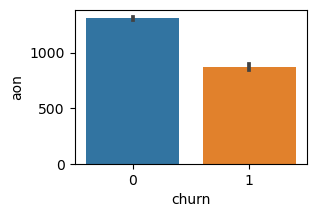

In [50]:
plt.figure(figsize = (3,2))
sns.barplot(x = 'churn', y = 'aon', data = data_df)
plt.show()

Below are a comparison of churn with all the flag columns created to differentiate parameters which are strongest indicators of churn.

ARPU , NUmber of Recharges done, total recharge amount, outgoing MOU, incoming MOU are some columns where we see people who have left have decreased there usage on these parameters than others who are still on network.

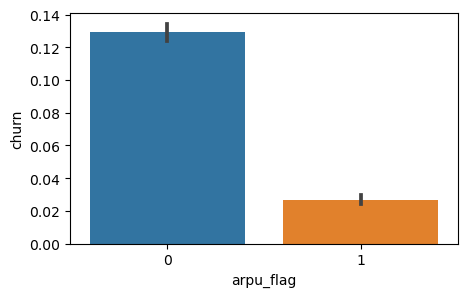

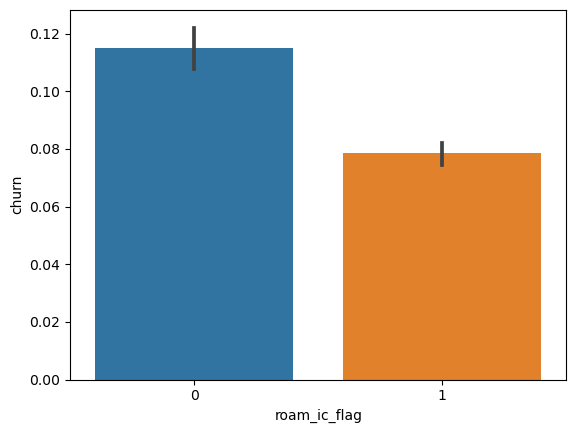

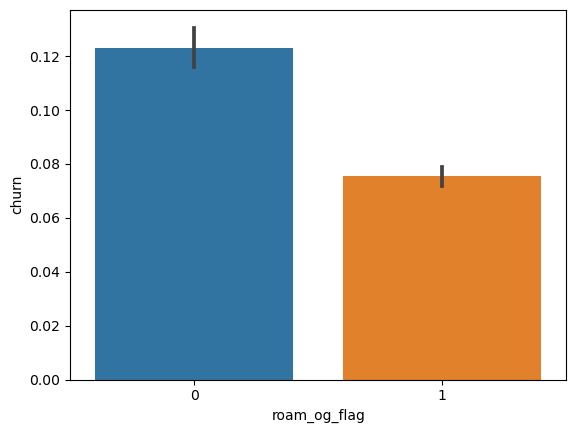

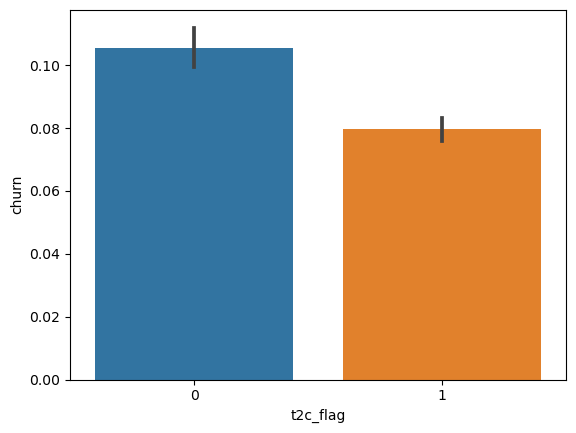

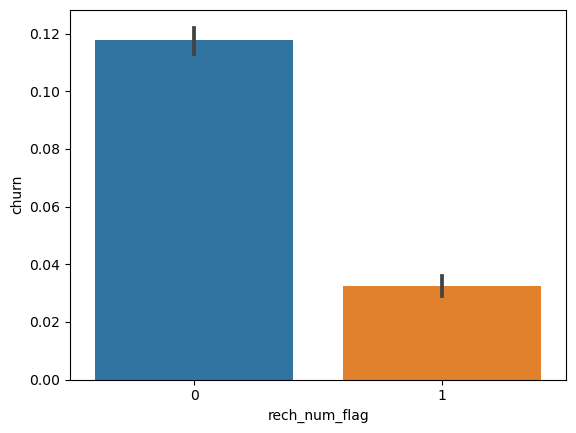

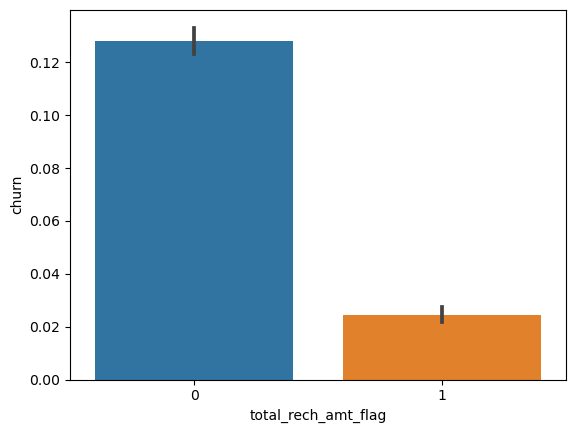

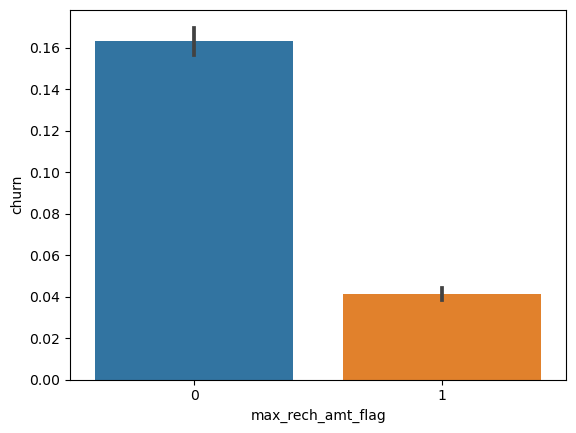

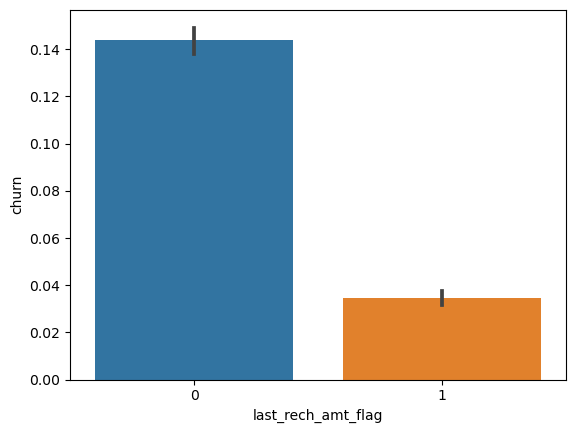

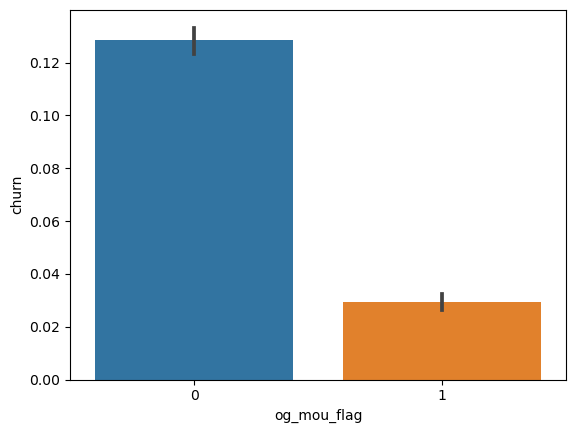

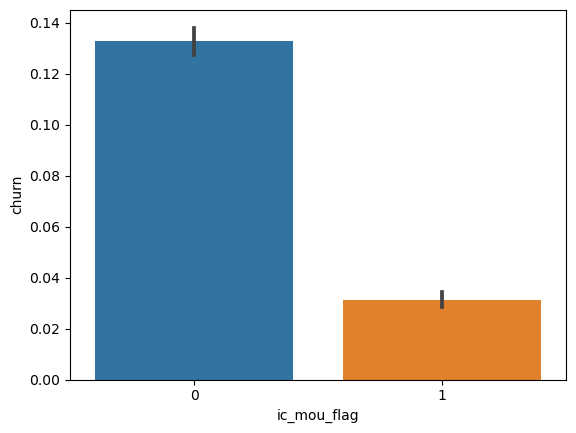

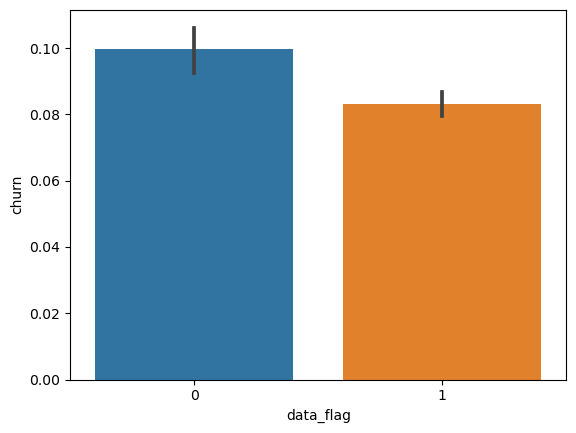

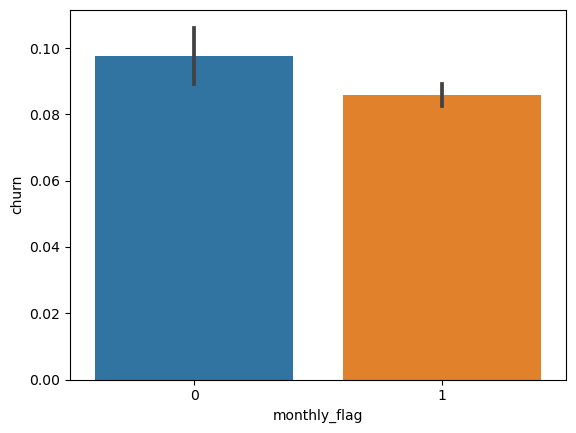

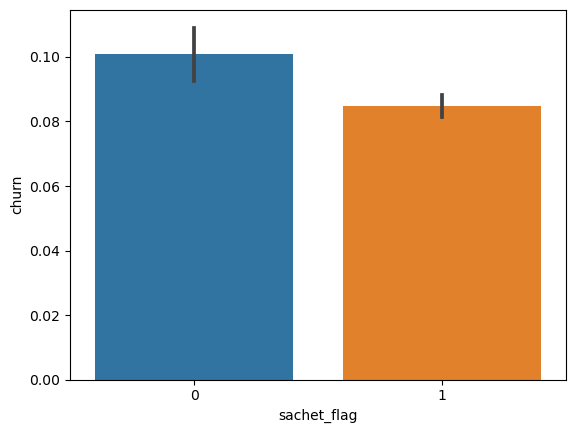

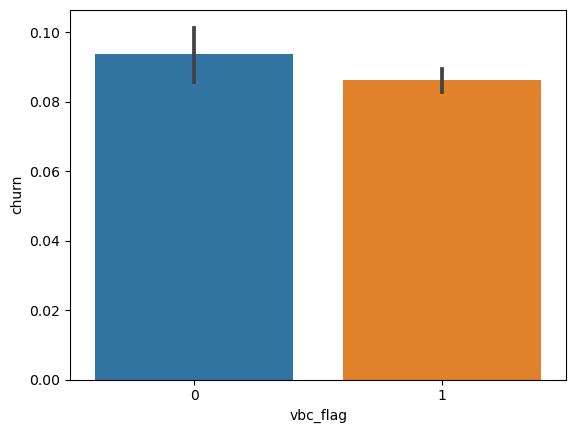

In [51]:
flag_cols = [col for col in data_df.columns if 'flag' in col]
plt.figure(figsize = (5,3))
for colm in flag_cols:
    sns.barplot(x = data_df[colm], y = data_df['churn'])
    plt.show()

Below graph shows if the amount of minutes spent in talking to customer care is reduced in action phase, those people are likely to churn.

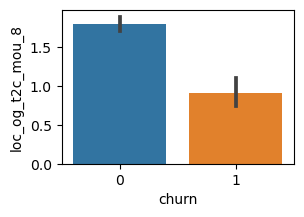

In [52]:
plt.figure(figsize = (3,2))
sns.barplot(x = 'churn', y = 'loc_og_t2c_mou_8', data = data_df)
plt.show()

From Below 2 scatterplots, we see that the there is a significant decrease in roaming incoming and outing calls from good phase to action phase for people who churn.

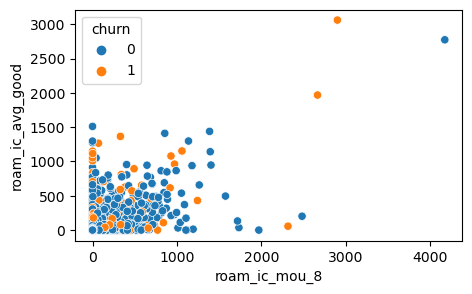

In [53]:
plt.figure(figsize = (5,3))
sns.scatterplot(y = 'roam_ic_avg_good', x = 'roam_ic_mou_8', data = data_df, hue = 'churn')
plt.show()

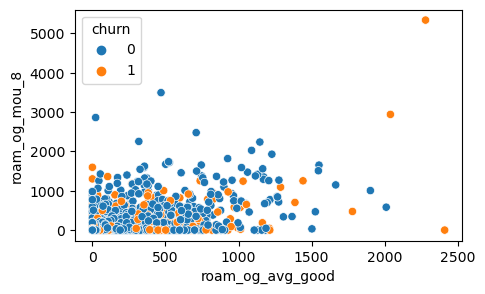

In [54]:
plt.figure(figsize = (5,3))
sns.scatterplot(x = 'roam_og_avg_good', y = 'roam_og_mou_8', data = data_df, hue = 'churn')
plt.show()

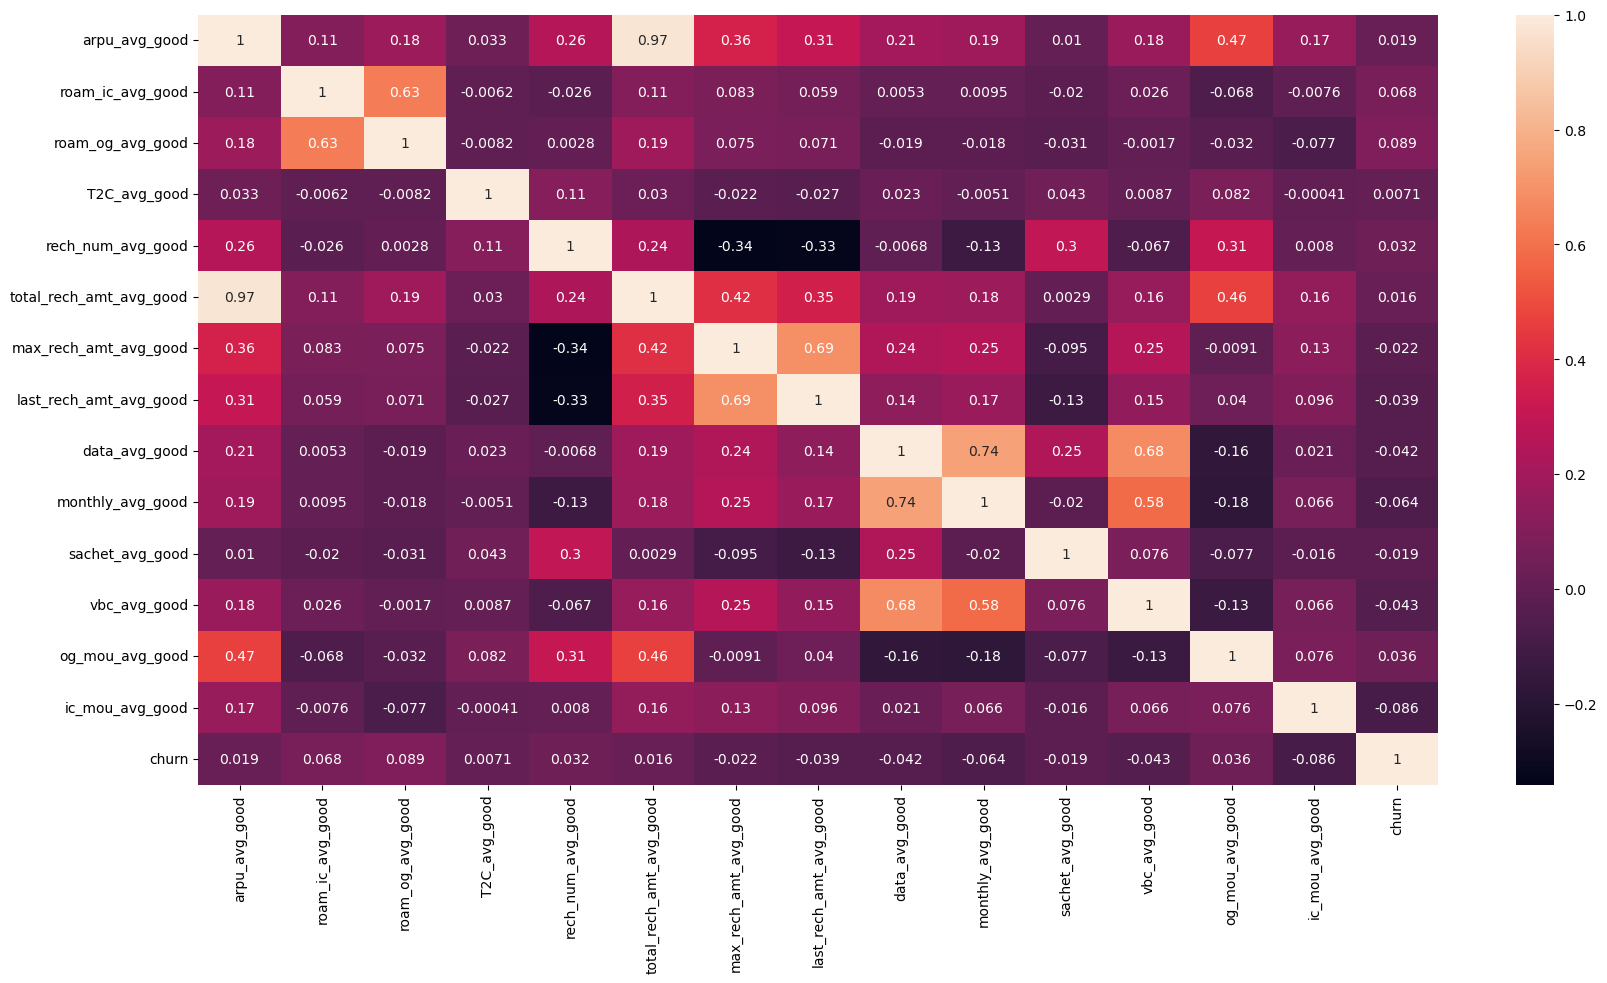

In [55]:
roam_cols = [col for col in data_df.columns if 'avg_good' in col]
roam_cols.append('churn')
plt.figure(figsize=(20,10))
sns.heatmap(data_df[roam_cols].corr(), annot=True)
plt.show()

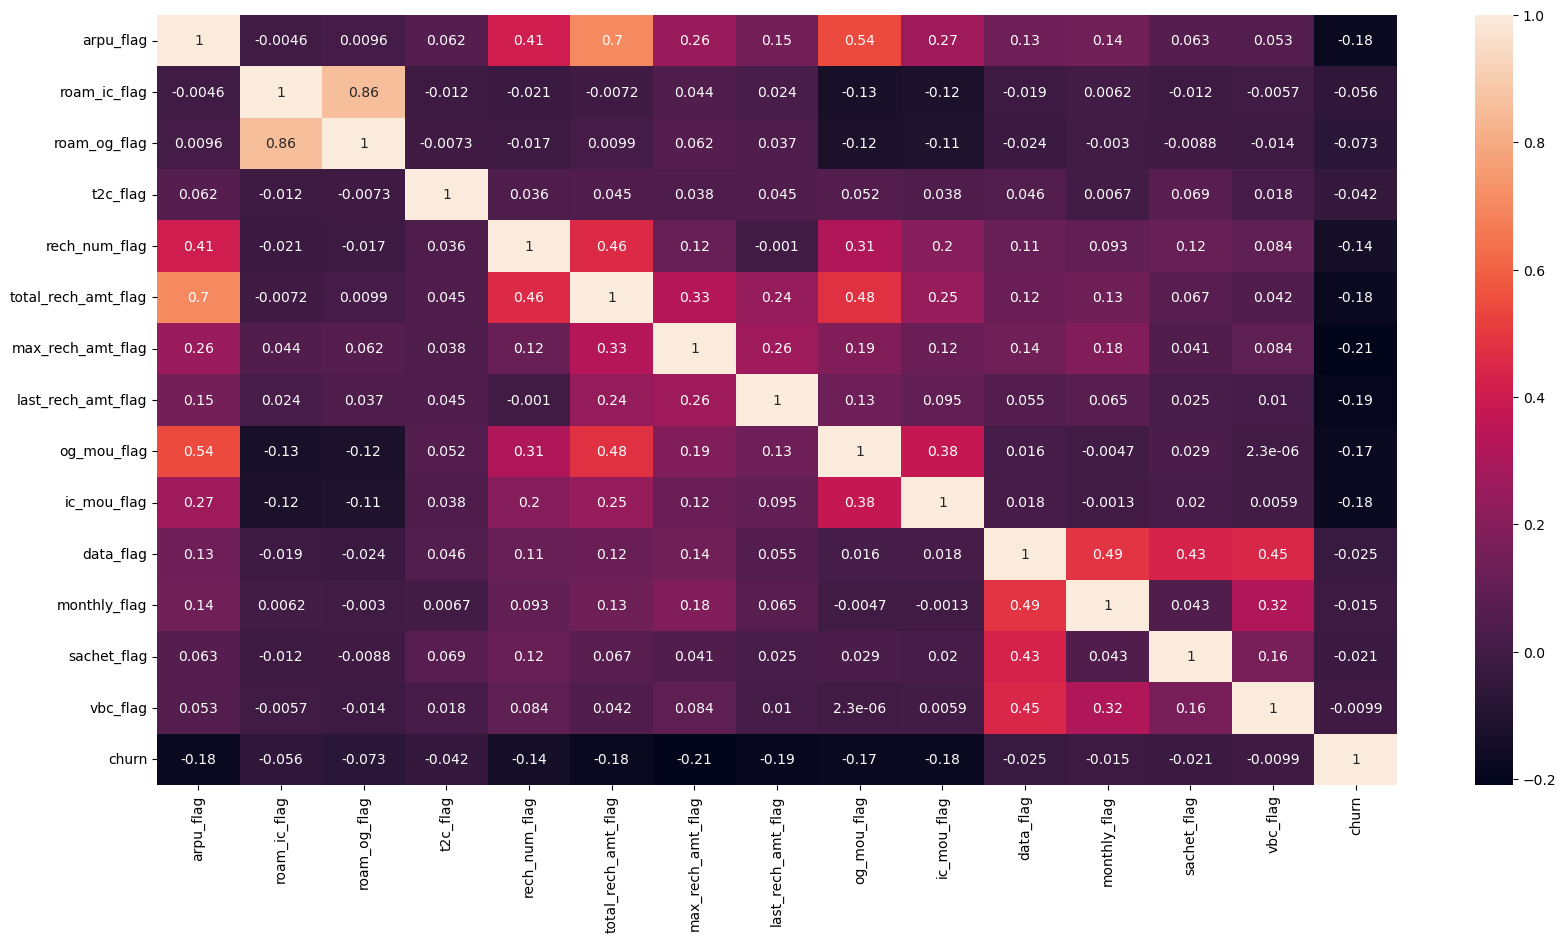

In [56]:
roam_cols = [col for col in data_df.columns if ('flag' in col)]
roam_cols.append('churn')
plt.figure(figsize=(20,10))
sns.heatmap(data_df[roam_cols].corr(), annot=True)
plt.show()

In [316]:
data_df.shape

(29647, 44)

Initialize X and y

In [317]:
X = data_df.drop('churn', axis = 1)
y = data_df['churn']

In [318]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Feature Scaling

In [319]:
# Instantiate the Scaler
scaler = StandardScaler()

In [320]:
avg_flag_col = [col for col in data_df.columns if '_flag' not in col]

In [321]:
avg_flag_col.remove('churn')

In [322]:
# Fit the data into scaler and transform
X_train[avg_flag_col] = scaler.fit_transform(X_train[avg_flag_col])

In [323]:
X_train.head()

,arpu_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,aon,aug_vbc_3g,total_og_mou_8,total_ic_mou_8,data_8,monthly_8,sachet_8,arpu_avg_good,roam_ic_avg_good,roam_og_avg_good,T2C_avg_good,rech_num_avg_good,total_rech_amt_avg_good,max_rech_amt_avg_good,last_rech_amt_avg_good,data_avg_good,monthly_avg_good,sachet_avg_good,vbc_avg_good,og_mou_avg_good,ic_mou_avg_good,arpu_flag,roam_ic_flag,roam_og_flag,t2c_flag,rech_num_flag,total_rech_amt_flag,max_rech_amt_flag,last_rech_amt_flag,og_mou_flag,ic_mou_flag,data_flag,monthly_flag,sachet_flag,vbc_flag
45551,-1.052234,-0.165787,-0.128170,-0.247603,-0.761111,-0.985959,-0.972993,-0.689555,-0.839835,-0.326789,-0.903088,-0.833767,-0.369656,-0.420102,0.112956,-0.345547,-0.227408,-0.254837,-0.254570,0.057378,-0.325430,-0.606487,-0.431649,-0.413327,-0.484357,0.402141,-0.348931,0.258065,-0.849662,0,1,1,1,0,0,0,0,0,0,1,1,0,1
37921,-0.592650,-0.173764,-0.202415,-0.247603,-0.971310,-0.985959,-0.972993,-0.689555,-0.990043,-0.326789,-0.839653,-0.338564,-0.369656,-0.420102,-0.325597,-0.908221,-0.227408,-0.274083,-0.254570,-0.985578,-0.383522,2.111136,-0.906687,-0.413327,-0.484357,-0.339130,-0.348931,-1.119049,-0.576079,1,1,1,1,0,0,0,1,1,1,1,1,1,1
71904,2.282160,-0.173764,-0.202415,-0.173134,-0.656011,0.973087,5.312539,-0.204401,1.121045,-0.326789,1.193558,0.507889,-0.369656,-0.420102,-0.325597,3.118891,-0.227408,-0.274083,0.502921,-0.869694,2.919992,9.066958,12.696677,-0.413327,-0.484357,-0.339130,-0.348931,1.851713,0.022874,0,1,1,0,0,0,0,0,0,1,1,1,1,1
38060,-1.061472,-0.173764,-0.202415,-0.247603,-1.076410,-0.985959,-0.972993,-0.689555,-0.824508,-0.326789,-0.903088,-0.833767,-0.369656,-0.420102,-0.325597,-0.440900,-0.227408,-0.274083,-0.254570,-0.174390,-0.495834,-0.690604,-0.587116,-0.413327,-0.484357,-0.339130,-0.348931,0.245664,-0.598856,0,1,1,1,0,0,0,0,0,0,1,1,1,1
56662,1.615368,-0.173764,-0.202415,-0.187736,0.710283,1.577968,-0.081046,0.251788,-0.798962,-0.326789,4.165633,-0.334410,-0.334009,-0.420102,0.112956,0.794767,-0.216956,-0.063443,-0.023737,0.057378,0.894508,-0.295902,0.198856,-0.413327,-0.484357,-0.339130,-0.348931,2.911300,-0.630506,1,0,0,0,1,1,1,1,1,1,1,1,1,1


In [324]:
# Transform the test set
X_test[avg_flag_col] = scaler.transform(X_test[avg_flag_col])
X_test.head()

,arpu_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,aon,aug_vbc_3g,total_og_mou_8,total_ic_mou_8,data_8,monthly_8,sachet_8,arpu_avg_good,roam_ic_avg_good,roam_og_avg_good,T2C_avg_good,rech_num_avg_good,total_rech_amt_avg_good,max_rech_amt_avg_good,last_rech_amt_avg_good,data_avg_good,monthly_avg_good,sachet_avg_good,vbc_avg_good,og_mou_avg_good,ic_mou_avg_good,arpu_flag,roam_ic_flag,roam_og_flag,t2c_flag,rech_num_flag,total_rech_amt_flag,max_rech_amt_flag,last_rech_amt_flag,og_mou_flag,ic_mou_flag,data_flag,monthly_flag,sachet_flag,vbc_flag
7316,-0.145170,-0.173764,-0.202415,-0.247603,-0.550912,-0.252721,-0.194785,-0.689555,1.070976,-0.326789,0.436632,3.877553,-0.369656,-0.420102,-0.325597,-0.421278,-0.227408,-0.274083,-0.254570,-0.000564,-0.367063,-0.412371,-0.535294,-0.413327,-0.484357,1.390501,-0.348931,0.160587,3.599977,1,1,1,1,0,0,1,0,1,1,1,1,0,1
60182,-0.391681,-0.173764,-0.202415,-0.247603,-0.866211,-0.344175,0.224251,0.758664,-0.046900,-0.326789,-0.638174,-0.078610,-0.369656,-0.420102,-0.325597,-0.580765,-0.043715,-0.093458,-0.254570,-1.101462,-0.452265,0.493503,0.945961,-0.413327,-0.484357,-0.339130,-0.348931,-0.868069,-0.465254,0,0,0,1,0,0,0,0,1,1,1,1,1,1
99763,-1.014689,-0.151429,-0.151205,-0.247603,-0.866211,-0.985959,-0.972993,-0.689555,-0.435193,-0.326789,-0.895484,-0.822106,-0.369656,-0.420102,-0.325597,-0.558004,0.573809,0.001599,-0.254570,-1.101462,-0.575227,0.972323,-0.906687,0.124784,0.305535,-0.092040,-0.348931,-0.901289,0.152807,0,0,0,1,0,0,0,1,0,0,0,0,0,1
91624,-0.865607,-0.073259,0.008708,0.866502,-0.656011,-0.825513,-0.374371,-0.689555,0.452772,-0.326789,-0.835664,-0.795431,-0.369656,-0.420102,-0.325597,-0.329270,-0.227408,-0.274083,1.397118,-0.579984,-0.468724,0.072919,0.086574,-0.413327,-0.484357,-0.339130,-0.348931,0.414363,-0.618835,0,1,1,0,0,0,0,0,0,0,1,1,1,1
11164,0.073375,-0.010510,-0.202415,-0.247603,0.605184,0.055336,-0.104991,-0.689555,1.855737,0.018482,-0.276243,0.335296,-0.197877,1.055017,0.990063,0.191551,-0.026903,-0.070107,-0.254570,0.984450,0.128658,-0.438253,-0.647576,-0.127627,0.305535,0.155050,0.233317,-0.254539,0.837648,0,0,0,1,0,0,1,0,0,0,0,1,1,0


In [325]:
X_train.shape, X_test.shape

((20752, 43), (8895, 43))

### Dealing with data imbalance - SMOTE technique

In [65]:
# Imporing SMOTE
from imblearn.over_sampling import SMOTE

In [66]:
# Instantiate SMOTE
smote = SMOTE(random_state=27)

In [67]:
# Fitting SMOTE to the train set
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### Model with PCA

In [68]:
# Instantiate PCA
pca_smote = PCA(random_state=42)

# Fit train set on PCA
pca_smote.fit(X_train_smote)

PCA(random_state=42)

In [69]:
# Principal components
pca_smote.components_

array([[ 3.39748671e-01,  1.05941051e-01,  1.39840884e-01, ...,
        -2.71816766e-02,  3.10990234e-03, -2.91865809e-02],
       [-4.63081269e-02,  4.08622908e-01,  3.79498775e-01, ...,
         1.12889268e-02,  6.63814142e-03,  1.31455541e-02],
       [ 1.91449096e-01,  3.67371921e-03,  4.49035052e-02, ...,
         7.13962024e-02,  1.36552941e-02,  7.38965469e-02],
       ...,
       [-2.49438475e-02,  8.54406472e-04, -3.71448310e-03, ...,
        -6.59729964e-01, -1.73979662e-01, -4.65983624e-02],
       [ 4.34236730e-01, -3.78564873e-03, -1.66163095e-03, ...,
        -4.99679776e-02, -3.58878660e-03, -2.54077837e-02],
       [-4.39689518e-01, -3.98703803e-04, -1.22575403e-04, ...,
         6.70057542e-05, -1.46331439e-03, -2.01156784e-02]])

In [70]:
# Cumuliative varinace of the PCs
variance_cumu = np.cumsum(pca_smote.explained_variance_ratio_)
print(variance_cumu)

[0.17515549 0.29580592 0.40165876 0.48048164 0.5412516  0.58436529
 0.6262366  0.66589906 0.7041535  0.73111166 0.75521571 0.77846095
 0.79997964 0.81905366 0.83732007 0.85430016 0.87012586 0.88240785
 0.89345824 0.90360862 0.91310976 0.92219749 0.9303118  0.93830418
 0.94515676 0.95180549 0.95784324 0.96340406 0.96856676 0.97333601
 0.97707662 0.98017412 0.98315813 0.98596645 0.98863759 0.9907625
 0.99282743 0.99468365 0.99630348 0.99770564 0.99884834 0.999484
 1.        ]


Text(0, 0.5, 'Cumulative Variance')

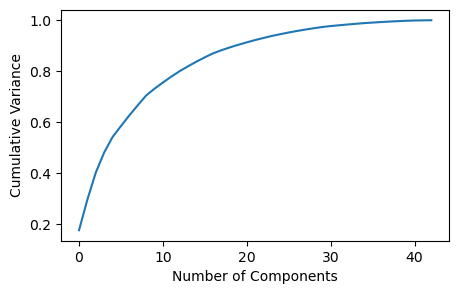

In [71]:
# Plotting scree plot
fig = plt.figure(figsize = (5,3))
plt.plot(variance_cumu)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')

In [72]:
# Instantiate PCA with 30 components
pca_smote = IncrementalPCA(n_components=30)

# Fit and transform the X_train
X_train_smote_pca = pca_smote.fit_transform(X_train_smote)
X_test_smote_pca = pca_smote.transform(X_test)

Using logistic regression model with GridSearch and PCA

In [73]:
# Creating KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_train_smote_pca, y_train_smote)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='recall', verbose=1)

In [74]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.068625,0.007605,0.009053,0.003774,0.01,{'C': 0.01},0.856840,0.857486,0.857332,0.849883,0.853480,0.855004,0.002950,1,0.856033,0.855152,0.855251,0.854686,0.855689,0.855362,0.000463
1,0.073905,0.006199,0.008864,0.006100,0.1,{'C': 0.1},0.855779,0.855618,0.854950,0.850404,0.851910,0.853732,0.002174,2,0.854320,0.854297,0.853670,0.851842,0.853641,0.853554,0.000905
2,0.074653,0.003971,0.002671,0.003283,1,{'C': 1},0.854984,0.855885,0.853626,0.850404,0.852172,0.853414,0.001961,6,0.854452,0.854494,0.853406,0.851776,0.853178,0.853461,0.000997
3,0.073133,0.009363,0.003879,0.004228,10,{'C': 10},0.854984,0.855885,0.853891,0.850404,0.852172,0.853467,0.001969,5,0.854518,0.854494,0.853472,0.851842,0.853244,0.853514,0.000984
4,0.064819,0.012344,0.006618,0.006094,100,{'C': 100},0.854984,0.855885,0.854156,0.850404,0.852172,0.853520,0.001983,3,0.854518,0.854560,0.853472,0.851842,0.853244,0.853527,0.000997
5,0.063262,0.010059,0.011383,0.007023,1000,{'C': 1000},0.854984,0.855885,0.854156,0.850404,0.852172,0.853520,0.001983,3,0.854518,0.854560,0.853472,0.851842,0.853244,0.853527,0.000997


In [75]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test sensitivity is {0} at C = {1}".format(best_score, best_C))

 The highest test sensitivity is 0.8550040715089583 at C = 0.01


In [76]:
# Instantiate the model with best C
logistic_pca = LogisticRegression(C=best_C)

In [77]:
# Fit the model on the train set
log_pca_model = logistic_pca.fit(X_train_smote_pca, y_train_smote)

In [78]:
# Predictions on the train set
y_train_pred = log_pca_model.predict(X_train_smote_pca)

# Prediction on the test set
y_test_pred = log_pca_model.predict(X_test_smote_pca)

In [79]:
# Confusion matrix
confusion_train = confusion_matrix(y_train_smote, y_train_pred)
print(confusion_train)

# Confusion matrix
confusion_test = confusion_matrix(y_test, y_test_pred)
print(confusion_test)

[[15830  3126]
 [ 2755 16201]]
[[6738 1360]
 [ 172  625]]


In [80]:
TP_train = confusion_train[1,1] # true positive 
TN_train = confusion_train[0,0] # true negatives
FP_train = confusion_train[0,1] # false positives
FN_train = confusion_train[1,0] # false negatives

TP_test = confusion_test[1,1] # true positive 
TN_test = confusion_test[0,0] # true negatives
FP_test = confusion_test[0,1] # false positives
FN_test = confusion_test[1,0] # false negatives

In [82]:
print("Train Set:")
# Accuracy
print("Accuracy:-",accuracy_score(y_train_smote, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP_train / float(TP_train+FN_train))

# Specificity
print("Specificity:-", TN_train / float(TN_train+FP_train))

print("Test Set:")
# Accuracy
print("Accuracy:-",accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP_test / float(TP_test+FN_test))

# Specificity
print("Specificity:-", TN_test / float(TN_test+FP_test))

Train Set:
Accuracy:- 0.8448776113104031
Sensitivity:- 0.8546634311036083
Specificity:- 0.8350917915171977
Test Set:
Accuracy:- 0.8277684092186621
Sensitivity:- 0.7841907151819323
Specificity:- 0.8320572980982959


Here model is performing well in 86% cases on train set and test set, with 33 features, but the sensitivity measure between train and test set is 87% and 72% respective which is not right. 

When reducing the number of PCA components to 30, the sensitivity measure changed - 85% on train set and 78% on test set.

Let us evaluate another class imbalance technique on this

### Dealing with Class imbalance - UnderSampling Technique

In [326]:
from imblearn.under_sampling import RandomUnderSampler
under_sample = RandomUnderSampler(random_state = 5)

In [327]:
# Fitting UnderSample to the train set
X_train_unsm, y_train_unsm = under_sample.fit_resample(X_train, y_train)

In [328]:
X_train_unsm.shape, y_train_unsm.shape

((3592, 43), (3592,))

### Model with PCA

In [85]:
# Instantiate PCA
pca_unsm = PCA(random_state=42)

# Fit train set on PCA
pca_unsm.fit(X_train_unsm)

PCA(random_state=42)

In [86]:
# Principal components
pca_unsm.components_

array([[ 2.55047704e-01,  2.10129478e-01,  3.23499666e-01, ...,
        -2.54871336e-02,  9.26041832e-03, -2.87490393e-02],
       [-9.61744712e-02,  3.53565844e-01,  3.37566502e-01, ...,
         3.48655828e-02,  7.65571246e-03,  4.13679818e-02],
       [ 2.41750177e-01, -2.27184963e-02,  3.64690547e-02, ...,
         5.12717836e-02,  6.98713269e-03,  5.33971154e-02],
       ...,
       [ 1.84822509e-02, -1.69482774e-03,  2.78100686e-03, ...,
         7.06076833e-01,  2.03773725e-01,  6.25365894e-02],
       [ 4.22679575e-01, -1.11307258e-03, -8.70974760e-03, ...,
        -4.46727258e-02, -1.24657806e-03, -1.92841550e-02],
       [ 4.20455422e-01, -2.42398779e-04,  9.94783372e-03, ...,
        -1.79227694e-02,  1.14706784e-02,  1.33959871e-02]])

In [87]:
# Cumuliative varinace of the PCs
variance_cumu = np.cumsum(pca_unsm.explained_variance_ratio_)
print(variance_cumu)

[0.16907488 0.29919014 0.39580711 0.47781786 0.53372007 0.58430477
 0.63200833 0.67179875 0.71093202 0.74274387 0.76475312 0.78613139
 0.80623168 0.82592161 0.84260486 0.85884407 0.87259057 0.88475231
 0.89658944 0.90702928 0.91643084 0.92550871 0.93375775 0.94188554
 0.94918391 0.9553893  0.96117031 0.96664751 0.97146151 0.97556811
 0.97918602 0.98208333 0.9848701  0.98750543 0.9901118  0.99216471
 0.99392873 0.99539853 0.99682381 0.99808638 0.99901598 0.99952912
 1.        ]


Text(0, 0.5, 'Cumulative Variance')

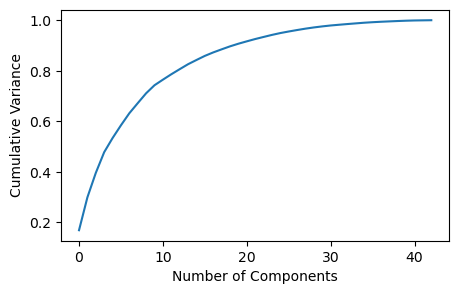

In [88]:
# Plotting scree plot
fig = plt.figure(figsize = (5,3))
plt.plot(variance_cumu)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')

In [89]:
# Instantiate PCA with 30 components
pca_unsm = IncrementalPCA(n_components=30)

# Fit and transform the X_train
X_train_unsm_pca = pca_unsm.fit_transform(X_train_unsm)
X_test_unsm_pca = pca_unsm.transform(X_test)

Using logistic regression model with GridSearch and PCA

In [90]:
# Creating KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_train_unsm_pca, y_train_unsm)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='recall', verbose=1)

In [91]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.007016,0.001683,0.004833,0.003466,0.01,{'C': 0.01},0.792818,0.800595,0.834646,0.839888,0.795014,0.812592,0.020373,1,0.827057,0.820548,0.809187,0.817361,0.821603,0.819151,0.005881
1,0.011634,0.003736,0.000000,0.000000,0.1,{'C': 0.1},0.787293,0.803571,0.826772,0.823034,0.803324,0.808799,0.014460,6,0.826360,0.819178,0.807774,0.814583,0.816028,0.816785,0.006067
2,0.011394,0.006869,0.007091,0.003671,1,{'C': 1},0.784530,0.803571,0.826772,0.825843,0.808864,0.809916,0.015643,5,0.825662,0.819863,0.808481,0.817361,0.816028,0.817479,0.005581
3,0.011618,0.003964,0.001572,0.003143,10,{'C': 10},0.784530,0.803571,0.826772,0.825843,0.811634,0.810470,0.015645,2,0.825662,0.819178,0.809187,0.816667,0.816028,0.817344,0.005316
4,0.012009,0.002288,0.005369,0.003203,100,{'C': 100},0.784530,0.803571,0.826772,0.825843,0.811634,0.810470,0.015645,2,0.825662,0.819863,0.809187,0.816667,0.816028,0.817481,0.005370
5,0.008481,0.007108,0.003412,0.005437,1000,{'C': 1000},0.784530,0.803571,0.826772,0.825843,0.811634,0.810470,0.015645,2,0.825662,0.819863,0.809187,0.816667,0.816028,0.817481,0.005370


In [92]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test sensitivity is {0} at C = {1}".format(best_score, best_C))

 The highest test sensitivity is 0.8125920155619075 at C = 0.01


In [93]:
# Instantiate the model with best C
logistic_pca = LogisticRegression(C=best_C)

In [94]:
# Fit the model on the train set
log_pca_model = logistic_pca.fit(X_train_unsm_pca, y_train_unsm)

In [95]:
# Predictions on the train set
y_train_pred = log_pca_model.predict(X_train_unsm_pca)

# Prediction on the test set
y_test_pred = log_pca_model.predict(X_test_unsm_pca)

In [96]:
# Confusion matrix
confusion_train = confusion_matrix(y_train_unsm, y_train_pred)
print(confusion_train)

# Confusion matrix
confusion_test = confusion_matrix(y_test, y_test_pred)
print(confusion_test)

[[1472  324]
 [ 324 1472]]
[[6564 1534]
 [ 129  668]]


In [97]:
TP_train = confusion_train[1,1] # true positive 
TN_train = confusion_train[0,0] # true negatives
FP_train = confusion_train[0,1] # false positives
FN_train = confusion_train[1,0] # false negatives

TP_test = confusion_test[1,1] # true positive 
TN_test = confusion_test[0,0] # true negatives
FP_test = confusion_test[0,1] # false positives
FN_test = confusion_test[1,0] # false negatives

In [98]:
print("Train Set:")
# Accuracy
print("Accuracy:-",accuracy_score(y_train_unsm, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP_train / float(TP_train+FN_train))

# Specificity
print("Specificity:-", TN_train / float(TN_train+FP_train))

print("Test Set:")
# Accuracy
print("Accuracy:-",accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP_test / float(TP_test+FN_test))

# Specificity
print("Specificity:-", TN_test / float(TN_test+FP_test))

Train Set:
Accuracy:- 0.8195991091314031
Sensitivity:- 0.8195991091314031
Specificity:- 0.8195991091314031
Test Set:
Accuracy:- 0.8130410342889264
Sensitivity:- 0.8381430363864492
Specificity:- 0.8105705112373426


Here model is performing well in 86% cases on train set and test set, with 33 features, but the sensitivity measure between train and test set is 87% and 73% respective which is a 1% improvement from SMOTE. 

When number of feautres is reduced to 30 the train sensitivity is 81% and test sensitivity 83%.
This looks like a go with technique.

Let us evaluate another class imbalance technique on this.


### Dealing with Class imbalance - Tomek Technique

In [99]:
from imblearn.under_sampling import TomekLinks
tomek_sample = TomekLinks(sampling_strategy='majority')

In [100]:
# Fitting SMOTE to the train set
X_train_tomk, y_train_tomk = tomek_sample.fit_resample(X_train, y_train)

### Model with PCA

In [101]:
# Instantiate PCA
pca_tomk = PCA(random_state=42)

# Fit train set on PCA
pca_tomk.fit(X_train_tomk)

PCA(random_state=42)

In [102]:
# Principal components
pca_tomk.components_

array([[ 3.22657085e-01,  5.11800410e-02,  7.45399125e-02, ...,
        -2.65853012e-02, -3.09475470e-03, -3.27579495e-02],
       [ 2.42316515e-01,  2.95015645e-02,  6.70868102e-02, ...,
         5.20004597e-02,  1.27287695e-02,  5.50387434e-02],
       [ 3.70473177e-02, -5.96620659e-02, -7.57349633e-02, ...,
        -1.16305973e-02, -4.35545958e-02, -2.02484748e-02],
       ...,
       [-7.93182939e-02, -3.29311532e-02,  3.47804196e-02, ...,
         2.68805957e-03,  5.30769021e-03,  4.17013374e-03],
       [ 5.73288675e-01, -6.13102108e-03, -1.28873473e-03, ...,
        -2.78116617e-02,  2.59379277e-04, -4.31320379e-03],
       [-2.79141692e-01,  4.47300022e-04, -5.57962676e-04, ...,
        -1.18000637e-02,  5.44590820e-03, -2.80396652e-02]])

In [103]:
# Cumuliative varinace of the PCs
variance_cumu = np.cumsum(pca_tomk.explained_variance_ratio_)
print(variance_cumu)

[0.18771442 0.31355415 0.4114921  0.48436133 0.53883509 0.58734835
 0.6313571  0.67223105 0.70044146 0.72844867 0.7548221  0.77866843
 0.80083104 0.82151176 0.8406844  0.85702845 0.87274274 0.88565426
 0.89696723 0.90773958 0.91669871 0.92516578 0.93304392 0.94066337
 0.9469988  0.95297265 0.95862793 0.96373997 0.96858566 0.97295382
 0.97666614 0.97988985 0.98301742 0.98598925 0.98852727 0.99081643
 0.99301665 0.99498173 0.99667144 0.99785054 0.99867393 0.99942456
 1.        ]


Text(0, 0.5, 'Cumulative Variance')

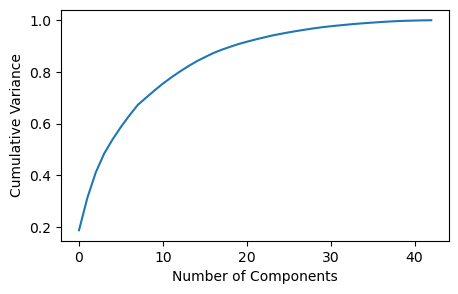

In [104]:
# Plotting scree plot
fig = plt.figure(figsize = (5,3))
plt.plot(variance_cumu)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')

In [105]:
# Instantiate PCA with 60 components
pca_tomk = IncrementalPCA(n_components=30)

# Fit and transform the X_train
X_train_tomk_pca = pca_tomk.fit_transform(X_train_tomk)
X_test_tomk_pca = pca_tomk.transform(X_test)

Using logistic regression model with GridSearch and PCA

In [106]:
# Creating KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_train_tomk_pca, y_train_tomk)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='recall', verbose=1)

In [107]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.043241,0.006723,0.007713,0.004683,0.01,{'C': 0.01},0.317073,0.283951,0.258427,0.278646,0.257426,0.279104,0.021739,6,0.303134,0.286005,0.277083,0.274788,0.287356,0.285673,0.010001
1,0.046250,0.008641,0.007259,0.005528,0.1,{'C': 0.1},0.408537,0.364198,0.356742,0.382812,0.381188,0.378695,0.017921,5,0.402589,0.385870,0.381944,0.368272,0.385776,0.384890,0.010953
2,0.045894,0.005812,0.004716,0.004631,1,{'C': 1},0.417683,0.391975,0.367978,0.393229,0.403465,0.394866,0.016301,4,0.413488,0.400136,0.397917,0.378895,0.396552,0.397397,0.011043
3,0.048505,0.011462,0.002770,0.002387,10,{'C': 10},0.417683,0.391975,0.370787,0.395833,0.405941,0.396444,0.015620,3,0.414169,0.400815,0.399306,0.380312,0.395833,0.398087,0.010850
4,0.041186,0.007029,0.007012,0.005878,100,{'C': 100},0.417683,0.395062,0.370787,0.395833,0.405941,0.397061,0.015492,1,0.414169,0.400815,0.399306,0.380312,0.395833,0.398087,0.010850
5,0.040118,0.007845,0.001102,0.002203,1000,{'C': 1000},0.417683,0.395062,0.370787,0.395833,0.405941,0.397061,0.015492,1,0.414169,0.400815,0.399306,0.380312,0.395833,0.398087,0.010850


In [108]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test sensitivity is {0} at C = {1}".format(best_score, best_C))

 The highest test sensitivity is 0.3970610198942004 at C = 100


In [109]:
# Instantiate the model with best C
logistic_pca = LogisticRegression(C=best_C)

In [110]:
# Fit the model on the train set
log_pca_model = logistic_pca.fit(X_train_tomk_pca, y_train_tomk)

In [111]:
# Predictions on the train set
y_train_pred = log_pca_model.predict(X_train_tomk_pca)

# Prediction on the test set
y_test_pred = log_pca_model.predict(X_test_tomk_pca)

In [112]:
# Confusion matrix
confusion_train = confusion_matrix(y_train_tomk, y_train_pred)
print(confusion_train)

# Confusion matrix
confusion_test = confusion_matrix(y_test, y_test_pred)
print(confusion_test)

[[18313   292]
 [ 1085   711]]
[[7932  166]
 [ 505  292]]


In [113]:
TP_train = confusion_train[1,1] # true positive 
TN_train = confusion_train[0,0] # true negatives
FP_train = confusion_train[0,1] # false positives
FN_train = confusion_train[1,0] # false negatives

TP_test = confusion_test[1,1] # true positive 
TN_test = confusion_test[0,0] # true negatives
FP_test = confusion_test[0,1] # false positives
FN_test = confusion_test[1,0] # false negatives

In [114]:
print("Train Set:")
# Accuracy
print("Accuracy:-",accuracy_score(y_train_tomk, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP_train / float(TP_train+FN_train))

# Specificity
print("Specificity:-", TN_train / float(TN_train+FP_train))

print("Test Set:")
# Accuracy
print("Accuracy:-",accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP_test / float(TP_test+FN_test))

# Specificity
print("Specificity:-", TN_test / float(TN_test+FP_test))

Train Set:
Accuracy:- 0.9325033086613401
Sensitivity:- 0.39587973273942095
Specificity:- 0.9843052942757323
Test Set:
Accuracy:- 0.9245643620011242
Sensitivity:- 0.36637390213299875
Specificity:- 0.9795011113855273


Here model is performing well in 93% cases on train set and test set, with 30 features, but the sensitivity measure between train and test set is 39% and 36% respective which is too poor. 

Let us evaluate another class imbalance technique on this.

### Dealing with Class imbalance - SMOTE+Tomek Technique

In [115]:
from imblearn.combine import SMOTETomek
smt_tmk = SMOTETomek(random_state=45)

In [116]:
# Fitting SMOTE-TOMEK to the train set
X_train_smtk, y_train_smtk = smt_tmk.fit_resample(X_train, y_train)

### Model with PCA

In [117]:
# Instantiate PCA
pca_smtk = PCA(random_state=42)

# Fit train set on PCA
pca_smtk.fit(X_train_smtk)

PCA(random_state=42)

In [118]:
# Principal components
pca_smtk.components_

array([[ 3.36890792e-01,  1.45083993e-01,  1.57759087e-01, ...,
        -2.43032302e-02,  3.60984932e-03, -2.72455062e-02],
       [-7.67348706e-02,  4.31178484e-01,  3.45340407e-01, ...,
         1.24523501e-02,  4.02337949e-03,  1.50037000e-02],
       [ 1.79941269e-01,  7.16699353e-03,  4.31076832e-02, ...,
         6.99466890e-02,  1.23099249e-02,  7.13377498e-02],
       ...,
       [-2.10704144e-02,  4.67855247e-04, -2.82048243e-03, ...,
        -6.57164222e-01, -1.70795011e-01, -4.76345150e-02],
       [ 4.47086412e-01, -5.26394556e-03, -1.32075639e-03, ...,
        -3.74704011e-02, -3.12339565e-03, -2.44537526e-02],
       [-4.33016203e-01, -1.80563189e-03,  1.53623761e-03, ...,
        -8.39258560e-04, -8.25145642e-04, -2.54264088e-02]])

In [119]:
# Cumuliative varinace of the PCs
variance_cumu = np.cumsum(pca_smtk.explained_variance_ratio_)
print(variance_cumu)

[0.17167441 0.29966099 0.40379092 0.48140165 0.54225311 0.58602624
 0.62793174 0.6691279  0.70746973 0.7353279  0.75864916 0.78147786
 0.80289571 0.82141841 0.83925037 0.85629681 0.87166059 0.88378493
 0.89477143 0.90486877 0.91426622 0.92326924 0.93123177 0.93893003
 0.94571118 0.95226419 0.958217   0.96369264 0.96878845 0.97351394
 0.97721966 0.98032054 0.98328261 0.98607848 0.98870549 0.99084944
 0.99291289 0.99475521 0.99637023 0.99774264 0.99887534 0.99950236
 1.        ]


Text(0, 0.5, 'Cumulative Variance')

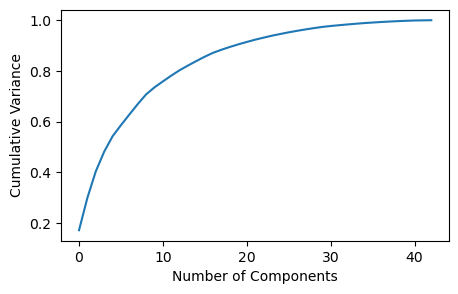

In [120]:
# Plotting scree plot
fig = plt.figure(figsize = (5,3))
plt.plot(variance_cumu)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')

In [121]:
# Instantiate PCA with 30 components
pca_smtk = IncrementalPCA(n_components=30)

# Fit and transform the X_train
X_train_smtk_pca = pca_smtk.fit_transform(X_train_smtk)
X_test_smtk_pca = pca_smtk.transform(X_test)

Using logistic regression model with GridSearch and PCA

In [122]:
# Creating KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_train_smtk_pca, y_train_smtk)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='recall', verbose=1)

In [123]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.057657,0.003576,0.009846,0.002949,0.01,{'C': 0.01},0.853160,0.852255,0.858739,0.852421,0.851599,0.853635,0.002600,1,0.854198,0.854753,0.854200,0.854722,0.853538,0.854282,0.000443
1,0.067306,0.008189,0.000613,0.001227,0.1,{'C': 0.1},0.851567,0.853581,0.858207,0.850859,0.851862,0.853215,0.002652,6,0.853210,0.854160,0.853805,0.854259,0.853406,0.853768,0.000409
2,0.067510,0.004221,0.008521,0.005090,1,{'C': 1},0.851567,0.853846,0.858207,0.851640,0.851862,0.853424,0.002535,5,0.853013,0.854292,0.853805,0.854391,0.853670,0.853834,0.000494
3,0.069442,0.010845,0.004223,0.003714,10,{'C': 10},0.851567,0.854111,0.858473,0.851379,0.851862,0.853478,0.002684,2,0.853079,0.854160,0.853739,0.854127,0.853538,0.853728,0.000401
4,0.066107,0.006148,0.000000,0.000000,100,{'C': 100},0.851567,0.854111,0.858473,0.851379,0.851862,0.853478,0.002684,2,0.853079,0.854160,0.853739,0.854127,0.853538,0.853728,0.000401
5,0.068998,0.007482,0.011588,0.006552,1000,{'C': 1000},0.851567,0.854111,0.858473,0.851379,0.851862,0.853478,0.002684,2,0.853079,0.854160,0.853739,0.854127,0.853538,0.853728,0.000401


In [124]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test sensitivity is {0} at C = {1}".format(best_score, best_C))

 The highest test sensitivity is 0.8536347009101014 at C = 0.01


In [125]:
# Instantiate the model with best C
logistic_pca = LogisticRegression(C=best_C)

In [126]:
# Fit the model on the train set
log_pca_model = logistic_pca.fit(X_train_smtk_pca, y_train_smtk)

In [127]:
# Predictions on the train set
y_train_pred = log_pca_model.predict(X_train_smtk_pca)

# Prediction on the test set
y_test_pred = log_pca_model.predict(X_test_smtk_pca)

In [128]:
# Confusion matrix
confusion_train = confusion_matrix(y_train_smtk, y_train_pred)
print(confusion_train)

# Confusion matrix
confusion_test = confusion_matrix(y_test, y_test_pred)
print(confusion_test)

[[15779  3172]
 [ 2758 16193]]
[[6719 1379]
 [ 169  628]]


In [129]:
TP_train = confusion_train[1,1] # true positive 
TN_train = confusion_train[0,0] # true negatives
FP_train = confusion_train[0,1] # false positives
FN_train = confusion_train[1,0] # false negatives

TP_test = confusion_test[1,1] # true positive 
TN_test = confusion_test[0,0] # true negatives
FP_test = confusion_test[0,1] # false positives
FN_test = confusion_test[1,0] # false negatives

In [130]:
print("Train Set:")
# Accuracy
print("Accuracy:-",accuracy_score(y_train_smtk, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP_train / float(TP_train+FN_train))

# Specificity
print("Specificity:-", TN_train / float(TN_train+FP_train))

print("Test Set:")
# Accuracy
print("Accuracy:-",accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP_test / float(TP_test+FN_test))

# Specificity
print("Specificity:-", TN_test / float(TN_test+FP_test))

Train Set:
Accuracy:- 0.8435438763125956
Sensitivity:- 0.8544667827555275
Specificity:- 0.8326209698696638
Test Set:
Accuracy:- 0.8259696458684654
Sensitivity:- 0.7879548306148055
Specificity:- 0.8297110397629044


Here model is performing well in 84% cases on train set and test set, with 30 features, but the sensitivity measure between train and test set is 85% and 78% respectively.

So let us use undersampling as the final technique to go with and build further models using it to compare performance.

# Decission Tree with GridsearchCV , PCA and undersampling techniques

In [131]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
dtree = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'recall',
                           cv = 5, 
                           verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train_unsm_pca,y_train_unsm)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='recall', verbose=1)

In [132]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.108029,0.017502,0.004291,0.003201,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.788301,0.788889,0.718663,0.813370,0.752089,0.772262,0.033177,3
1,0.106427,0.013013,0.000966,0.001932,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.788301,0.788889,0.718663,0.813370,0.752089,0.772262,0.033177,3
2,0.082613,0.008567,0.004719,0.006843,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.701950,0.788889,0.740947,0.754875,0.777159,0.752764,0.030418,5
3,0.089388,0.011263,0.004395,0.005142,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.701950,0.788889,0.740947,0.754875,0.777159,0.752764,0.030418,5
4,0.137913,0.012436,0.002736,0.003797,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.788301,0.769444,0.732591,0.818942,0.752089,0.772273,0.029749,1
5,0.126784,0.017651,0.009332,0.005883,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.788301,0.769444,0.732591,0.818942,0.752089,0.772273,0.029749,1
6,0.101975,0.013458,0.000000,0.000000,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.701950,0.788889,0.740947,0.754875,0.777159,0.752764,0.030418,5
7,0.104318,0.005901,0.003231,0.006200,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.701950,0.788889,0.740947,0.754875,0.777159,0.752764,0.030418,5


In [133]:
# Printing the optimal sensitivity score and hyperparameters
print("Best sensitivity:-", grid_search.best_score_)
print(grid_search.best_estimator_)

Best sensitivity:- 0.772273290003095
DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50)


In [134]:
# Model with optimal hyperparameters
dt_unsm_pca_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=100)

dt_unsm_pca_model.fit(X_train_unsm_pca, y_train_unsm)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=100,
                       random_state=100)

In [135]:
# Predictions on the train set
y_train_pred = dt_unsm_pca_model.predict(X_train_unsm_pca)

# Prediction on the test set
y_test_pred = dt_unsm_pca_model.predict(X_test_unsm_pca)

In [136]:
# Confusion matrix
confusion_train = confusion_matrix(y_train_unsm, y_train_pred)
print(confusion_train)

# Confusion matrix
confusion_test = confusion_matrix(y_test, y_test_pred)
print(confusion_test)

[[1454  342]
 [ 319 1477]]
[[6303 1795]
 [ 147  650]]


In [137]:
TP_train = confusion_train[1,1] # true positive 
TN_train = confusion_train[0,0] # true negatives
FP_train = confusion_train[0,1] # false positives
FN_train = confusion_train[1,0] # false negatives

TP_test = confusion_test[1,1] # true positive 
TN_test = confusion_test[0,0] # true negatives
FP_test = confusion_test[0,1] # false positives
FN_test = confusion_test[1,0] # false negatives

In [138]:
print("Train Set:")
# Accuracy
print("Accuracy:-",accuracy_score(y_train_unsm, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP_train / float(TP_train+FN_train))

# Specificity
print("Specificity:-", TN_train / float(TN_train+FP_train))

print("Test Set:")
# Accuracy
print("Accuracy:-",accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP_test / float(TP_test+FN_test))

# Specificity
print("Specificity:-", TN_test / float(TN_test+FP_test))

Train Set:
Accuracy:- 0.8159799554565702
Sensitivity:- 0.8223830734966593
Specificity:- 0.8095768374164811
Test Set:
Accuracy:- 0.7816750983698707
Sensitivity:- 0.8155583437892095
Specificity:- 0.7783403309459126


# This model looks good as it is performing well on both train as well as test sets.

Let us see if Decision Tree gives better performance without PCA.

# Decission Tree without PCA

In [157]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
dtree = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'recall',
                           cv = 5, 
                           verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train_unsm, y_train_unsm)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='recall', verbose=1)

In [158]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.052976,0.008638,0.003752,0.003895,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.760446,0.819444,0.821727,0.779944,0.766017,0.789516,0.026162,7
1,0.052952,0.013185,0.009732,0.005439,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.760446,0.819444,0.821727,0.779944,0.766017,0.789516,0.026162,7
2,0.045441,0.002162,0.005016,0.005532,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.771588,0.827778,0.816156,0.774373,0.785515,0.795082,0.022740,1
3,0.052360,0.006595,0.005966,0.005826,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.771588,0.827778,0.816156,0.774373,0.785515,0.795082,0.022740,1
4,0.054109,0.006287,0.009704,0.007958,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.779944,0.819444,0.821727,0.779944,0.766017,0.793415,0.022771,5
5,0.068089,0.012394,0.005067,0.006519,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.779944,0.819444,0.821727,0.779944,0.766017,0.793415,0.022771,5
6,0.056252,0.005829,0.007912,0.004495,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.771588,0.827778,0.816156,0.774373,0.785515,0.795082,0.022740,1
7,0.056453,0.010064,0.003534,0.007068,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.771588,0.827778,0.816156,0.774373,0.785515,0.795082,0.022740,1


In [159]:
# Printing the optimal sensitivity score and hyperparameters
print("Best sensitivity:-", grid_search.best_score_)
print(grid_search.best_estimator_)

Best sensitivity:- 0.7950820179510988
DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, min_samples_split=50)


In [160]:
# Model with optimal hyperparameters
dt_unsm_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=100,
                                  min_samples_split=50)

dt_unsm_model.fit(X_train_unsm, y_train_unsm)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=100, min_samples_split=50,
                       random_state=100)

In [161]:
# Predictions on the train set
y_train_pred = dt_unsm_model.predict(X_train_unsm)

# Prediction on the test set
y_test_pred = dt_unsm_model.predict(X_test)

In [162]:
# Confusion matrix
confusion_train = confusion_matrix(y_train_unsm, y_train_pred)
print(confusion_train)

# Confusion matrix
confusion_test = confusion_matrix(y_test, y_test_pred)
print(confusion_test)

[[1558  238]
 [ 348 1448]]
[[6907 1191]
 [ 169  628]]


In [163]:
TP_train = confusion_train[1,1] # true positive 
TN_train = confusion_train[0,0] # true negatives
FP_train = confusion_train[0,1] # false positives
FN_train = confusion_train[1,0] # false negatives

TP_test = confusion_test[1,1] # true positive 
TN_test = confusion_test[0,0] # true negatives
FP_test = confusion_test[0,1] # false positives
FN_test = confusion_test[1,0] # false negatives

In [164]:
print("Train Set:")
# Accuracy
print("Accuracy:-",accuracy_score(y_train_unsm, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP_train / float(TP_train+FN_train))

# Specificity
print("Specificity:-", TN_train / float(TN_train+FP_train))

print("Test Set:")
# Accuracy
print("Accuracy:-",accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP_test / float(TP_test+FN_test))

# Specificity
print("Specificity:-", TN_test / float(TN_test+FP_test))

Train Set:
Accuracy:- 0.8368596881959911
Sensitivity:- 0.8062360801781737
Specificity:- 0.8674832962138085
Test Set:
Accuracy:- 0.8471051152332771
Sensitivity:- 0.7879548306148055
Specificity:- 0.8529266485551988


Decission Tree model with PCA is performing better than without PCA.

And in comparison to logistic model, with 81% sensitivity on train set and 83% sensitivity on test set; A Decision Tree is giving better results with 82% sensitivity on train set and 81% sensitivity on test set.

# Random Forest with GridSearchCV, PCA and Undersampling technique

In [165]:
param_grid = {
    'max_depth': range(5,10,5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'n_estimators': [50,100], 
    'max_features': [20,25, 30, 35]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1,
                           verbose = 1, 
                           return_train_score=True)

# Fit the model
grid_search.fit(X_train_unsm_pca, y_train_unsm)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(5, 10, 5),
                         'max_features': [20, 25, 30, 35],
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50),
                         'n_estimators': [50, 100]},
             return_train_score=True, verbose=1)

In [166]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.8062367474984994 using {'max_depth': 5, 'max_features': 20, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 50}


In [170]:
# model with the best hyperparameters

rfc_unsm_pca_model = RandomForestClassifier(bootstrap=True,
                             max_depth=5,
                             min_samples_leaf=50, 
                             min_samples_split=50,
                             max_features=20,
                             n_estimators=50)

In [171]:
# Fit the model
rfc_unsm_pca_model.fit(X_train_unsm_pca, y_train_unsm)

RandomForestClassifier(max_depth=5, max_features=20, min_samples_leaf=50,
                       min_samples_split=50, n_estimators=50)

In [174]:
# Predictions on the train set
y_train_pred = rfc_unsm_pca_model.predict(X_train_unsm_pca)

# Prediction on the test set
y_test_pred = rfc_unsm_pca_model.predict(X_test_unsm_pca)

In [175]:
# Confusion matrix
confusion_train = confusion_matrix(y_train_unsm, y_train_pred)
print(confusion_train)

# Confusion matrix
confusion_test = confusion_matrix(y_test, y_test_pred)
print(confusion_test)

[[1533  263]
 [ 356 1440]]
[[6756 1342]
 [ 162  635]]


In [176]:
TP_train = confusion_train[1,1] # true positive 
TN_train = confusion_train[0,0] # true negatives
FP_train = confusion_train[0,1] # false positives
FN_train = confusion_train[1,0] # false negatives

TP_test = confusion_test[1,1] # true positive 
TN_test = confusion_test[0,0] # true negatives
FP_test = confusion_test[0,1] # false positives
FN_test = confusion_test[1,0] # false negatives

In [177]:
print('Train Set: ')
# Accuracy
print("Accuracy:-",accuracy_score(y_train_unsm, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP_train / float(TP_train+FN_train))

# Specificity
print("Specificity:-", TN_train / float(TN_train+FP_train))

print('Test Set: ')
# Accuracy
print("Accuracy:-",accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP_test / float(TP_test+FN_test))

# Specificity
print("Specificity:-", TN_test / float(TN_test+FP_test))

Train Set: 
Accuracy:- 0.8276726057906458
Sensitivity:- 0.8017817371937639
Specificity:- 0.8535634743875279
Test Set: 
Accuracy:- 0.8309162450815064
Sensitivity:- 0.7967377666248432
Specificity:- 0.8342800691528772


# Random Forest without PCA

In [178]:
param_grid = {
    'max_depth': range(5,10,5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'n_estimators': [50,100], 
    'max_features': [20,25, 30, 35]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1,
                           verbose = 1, 
                           return_train_score=True)

# Fit the model
grid_search.fit(X_train_unsm, y_train_unsm)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(5, 10, 5),
                         'max_features': [20, 25, 30, 35],
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50),
                         'n_estimators': [50, 100]},
             return_train_score=True, verbose=1)

In [179]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.8415943401445554 using {'max_depth': 5, 'max_features': 30, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 100}


In [181]:
# model with the best hyperparameters

rfc_unsm_model = RandomForestClassifier(bootstrap=True,
                             max_depth=5,
                             min_samples_leaf=50, 
                             min_samples_split=50,
                             max_features=30,
                             n_estimators=100)

In [182]:
# Fit the model
rfc_unsm_model.fit(X_train_unsm, y_train_unsm)

RandomForestClassifier(max_depth=5, max_features=30, min_samples_leaf=50,
                       min_samples_split=50)

In [184]:
# Predictions on the train set
y_train_pred = rfc_unsm_model.predict(X_train_unsm)

# Prediction on the test set
y_test_pred = rfc_unsm_model.predict(X_test)

In [185]:
# Confusion matrix
confusion_train = confusion_matrix(y_train_unsm, y_train_pred)
print(confusion_train)

# Confusion matrix
confusion_test = confusion_matrix(y_test, y_test_pred)
print(confusion_test)

[[1610  186]
 [ 304 1492]]
[[7148  950]
 [ 148  649]]


In [186]:
TP_train = confusion_train[1,1] # true positive 
TN_train = confusion_train[0,0] # true negatives
FP_train = confusion_train[0,1] # false positives
FN_train = confusion_train[1,0] # false negatives

TP_test = confusion_test[1,1] # true positive 
TN_test = confusion_test[0,0] # true negatives
FP_test = confusion_test[0,1] # false positives
FN_test = confusion_test[1,0] # false negatives

In [187]:
print('Train Set: ')
# Accuracy
print("Accuracy:-",accuracy_score(y_train_unsm, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP_train / float(TP_train+FN_train))

# Specificity
print("Specificity:-", TN_train / float(TN_train+FP_train))

print('Test Set: ')
# Accuracy
print("Accuracy:-",accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP_test / float(TP_test+FN_test))

# Specificity
print("Specificity:-", TN_test / float(TN_test+FP_test))

Train Set: 
Accuracy:- 0.8635857461024499
Sensitivity:- 0.8307349665924276
Specificity:- 0.8964365256124721
Test Set: 
Accuracy:- 0.8765598650927487
Sensitivity:- 0.8143036386449184
Specificity:- 0.8826870832304272


# The above model seems to be performing best.

## Logistic regression with No PCA

In [293]:
logreg = LogisticRegression()

In [294]:
X_train_sm=sm.add_constant(X_train_unsm,has_constant="add")
X_test_sm=sm.add_constant(X_test,has_constant="add")

In [295]:
model1=sm.GLM(np.array(y_train_unsm),X_train_sm,family=sm.families.Binomial())
# Binomial --> Binary Classification
result1=model1.fit()
result1.summary()
#Generalised Linear Model

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 3592
Model:                            GLM   Df Residuals:                     3548
Model Family:                Binomial   Df Model:                           43
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1515.5
Date:                Tue, 09 Jul 2024   Deviance:                       3031.1
Time:                        12:53:48   Pearson chi2:                 2.07e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4187
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.6156      0.293     -2.103      0.036      -1.189      -0.042
arpu_8                     -0.0133      0.245     -0.054      0.957      -0.494       0.467
roam_ic_mou_8               0.0284      0.070      0.406      0.684      -0.109       0.165
roam_og_mou_8               0.1288      0.074      1.750      0.080      -0.015       0.273
loc_og_t2c_mou_8            0.1066      0.064      1.674      0.094      -0.018       0.231
total_rech_num_8           -0.3679      0.118     -3.112      0.002      -0.600      -0.136
total_rech_amt_8           -0.1390      0.281     -0.495      0.620      -0.689       0.411
max_rech_amt_8              0.1960      0.101      1.943      0.052      -0.002       0.394
last_day_rch_amt_8         -0.2102      0.082     -2.574      0.010      -0.370      -0.050
aon                        -0.3204      0.055     -5.805      0.000      -0.429      -0.212
aug_vbc_3g                  0.2381      0.107      2.220      0.026       0.028       0.448
total_og_mou_8             -0.6270      0.140     -4.494      0.000      -0.901      -0.354
total_ic_mou_8             -1.6552      0.167     -9.888      0.000      -1.983      -1.327
data_8                     -0.4110      0.154     -2.662      0.008      -0.714      -0.108
monthly_8                  -0.7149      0.146     -4.901      0.000      -1.001      -0.429
sachet_8                   -0.5571      0.108     -5.142      0.000      -0.769      -0.345
arpu_avg_good               0.1558      0.255      0.610      0.542      -0.344       0.656
roam_ic_avg_good            0.1067      0.071      1.497      0.134      -0.033       0.246
roam_og_avg_good            0.1124      0.076      1.488      0.137      -0.036       0.260
T2C_avg_good                0.0276      0.047      0.589      0.556      -0.064       0.120
rech_num_avg_good           0.1117      0.090      1.244      0.213      -0.064       0.288
total_rech_amt_avg_good     0.2304      0.280      0.822      0.411      -0.319       0.780
max_rech_amt_avg_good       0.1577      0.087      1.804      0.071      -0.014       0.329
last_rech_amt_avg_good     -0.1507      0.070     -2.148      0.032      -0.288      -0.013
data_avg_good               0.5985      0.156      3.826      0.000       0.292       0.905
monthly_avg_good           -0.2854      0.145     -1.963      0.050      -0.570      -0.000
sachet_avg_good             0.2497      0.084      2.962      0.003       0.084       0.415
vbc_avg_good               -0.2613      0.110     -2.375      0.018      -0.477      -0.046
og_mou_avg_good             0.3363      0.105      3.215      0.001       0.131       0.541
ic_mou_avg_good             0.4275      0.109      3.922      0.000       0.214       0.641
arpu_flag                   0.1190      0.181  

### Getting parameters from RFE 

In [329]:
rfe = RFE(estimator=logreg, n_features_to_select=15)
rfe.fit(X_train_unsm, y_train_unsm)

RFE(estimator=LogisticRegression(), n_features_to_select=15)

In [330]:
list(zip(X_train_unsm.columns, rfe.support_, rfe.ranking_))

[('arpu_8', False, 27),
 ('roam_ic_mou_8', False, 26),
 ('roam_og_mou_8', False, 9),
 ('loc_og_t2c_mou_8', False, 21),
 ('total_rech_num_8', False, 2),
 ('total_rech_amt_8', False, 10),
 ('max_rech_amt_8', False, 11),
 ('last_day_rch_amt_8', False, 12),
 ('aon', True, 1),
 ('aug_vbc_3g', False, 8),
 ('total_og_mou_8', True, 1),
 ('total_ic_mou_8', True, 1),
 ('data_8', False, 4),
 ('monthly_8', True, 1),
 ('sachet_8', True, 1),
 ('arpu_avg_good', False, 16),
 ('roam_ic_avg_good', False, 15),
 ('roam_og_avg_good', False, 23),
 ('T2C_avg_good', False, 28),
 ('rech_num_avg_good', False, 20),
 ('total_rech_amt_avg_good', True, 1),
 ('max_rech_amt_avg_good', False, 19),
 ('last_rech_amt_avg_good', False, 18),
 ('data_avg_good', False, 3),
 ('monthly_avg_good', False, 5),
 ('sachet_avg_good', True, 1),
 ('vbc_avg_good', False, 7),
 ('og_mou_avg_good', True, 1),
 ('ic_mou_avg_good', True, 1),
 ('arpu_flag', False, 22),
 ('roam_ic_flag', False, 17),
 ('roam_og_flag', True, 1),
 ('t2c_flag', Fa

In [331]:
col = X_train_unsm.columns[rfe.support_]
col

Index(['aon', 'total_og_mou_8', 'total_ic_mou_8', 'monthly_8', 'sachet_8',
       'total_rech_amt_avg_good', 'sachet_avg_good', 'og_mou_avg_good',
       'ic_mou_avg_good', 'roam_og_flag', 'total_rech_amt_flag',
       'max_rech_amt_flag', 'last_rech_amt_flag', 'og_mou_flag',
       'sachet_flag'],
      dtype='object')

In [332]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train_unsm[col]

In [333]:
# Adding constant
X_train_rfe = sm.add_constant(X_train_rfe)

## Model-1 with RFE selected columns

In [334]:
logm1 = sm.GLM(np.array(y_train_unsm),X_train_rfe, family = sm.families.Binomial())
result_logm1 = logm1.fit()
result_logm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 3592
Model:                            GLM   Df Residuals:                     3576
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1568.4
Date:                Tue, 09 Jul 2024   Deviance:                       3136.8
Time:                        13:08:55   Pearson chi2:                 6.86e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4013
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.5606      0.177     -3.165      0.002      -0.908      -0.213
aon                        -0.3012      0.052     -5.737      0.000      -0.404      -0.198
total_og_mou_8             -0.9093      0.112     -8.153      0.000      -1.128      -0.691
total_ic_mou_8             -1.8315      0.150    -12.237      0.000      -2.125      -1.538
monthly_8                  -0.7913      0.085     -9.337      0.000      -0.957      -0.625
sachet_8                   -0.6524      0.098     -6.686      0.000      -0.844      -0.461
total_rech_amt_avg_good     0.5845      0.085      6.895      0.000       0.418       0.751
sachet_avg_good             0.3026      0.079      3.828      0.000       0.148       0.458
og_mou_avg_good             0.2980      0.085      3.513      0.000       0.132       0.464
ic_mou_avg_good             0.5100      0.097      5.250      0.000       0.320       0.700
roam_og_flag               -0.4497      0.105     -4.299      0.000      -0.655      -0.245
total_rech_amt_flag         0.3739      0.132      2.837      0.005       0.116       0.632
max_rech_amt_flag          -0.4730      0.100     -4.717      0.000      -0.670      -0.276
last_rech_amt_flag         -0.8407      0.097     -8.698      0.000      -1.030      -0.651
og_mou_flag                -0.2786      0.133     -2.103      0.036      -0.538      -0.019
sachet_flag                 0.3609      0.146      2.471      0.013       0.075       0.647
===========================================================================================
"""

In [302]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,13.22
7,sachet_avg_good,2.42
3,total_ic_mou_8,2.29
8,og_mou_avg_good,2.10
2,total_og_mou_8,2.06
9,ic_mou_avg_good,2.01
5,sachet_8,1.97
14,og_mou_flag,1.73
11,total_rech_amt_flag,1.68
6,total_rech_amt_avg_good,1.59


In [335]:
# Predictions on the train set
y_train_pred = result_logm1.predict(X_train_rfe)

In [347]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.29916349, 0.38166658, 0.6105347 , 0.29833272, 0.44236601,
       0.36635691, 0.09206105, 0.49452832, 0.80320104, 0.24466438])

##### Creating a dataframe with the actual churn flag and the predicted probabilities

In [349]:
y_train_pred_final = pd.DataFrame({'Churn':y_train_unsm.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train_unsm.index
y_train_pred_final.head()

,Churn,Churn_Prob,CustID
0,0,0.299163,99505
1,0,0.381667,65389
2,0,0.610535,48250
3,0,0.298333,15446
4,0,0.442366,68783


##### Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

In [350]:
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted
0,0,0.299163,99505,0
1,0,0.381667,65389,0
2,0,0.610535,48250,1
3,0,0.298333,15446,0
4,0,0.442366,68783,0


In [351]:
from sklearn import metrics

In [352]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

[[1449  347]
 [ 322 1474]]


In [354]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.8137527839643652


In [355]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [336]:
# Creating X_test dataframe with RFE selected variables
X_test_rfe = X_test[col]

In [357]:
print("Train Set:")

# Sensitivity
print("Sensitivity:-",TP_train / float(TP_train+FN_train))

# Specificity
print("Specificity:-", TN_train / float(TN_train+FP_train))


Train Set:
Sensitivity:- 0.8307349665924276
Specificity:- 0.8964365256124721


In [358]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [359]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )

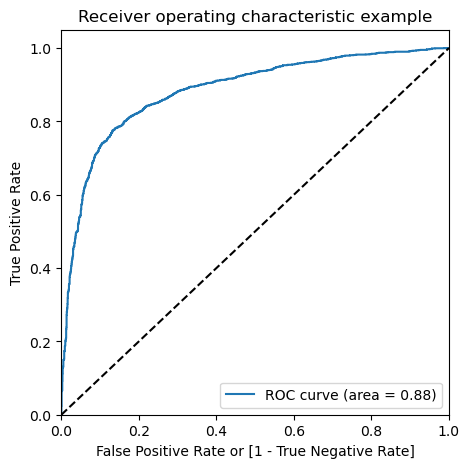

In [360]:
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

### Step 10: Finding Optimal Cutoff Point

Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [361]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.299163,99505,0,1,1,1,0,0,0,0,0,0,0
1,0,0.381667,65389,0,1,1,1,1,0,0,0,0,0,0
2,0,0.610535,48250,1,1,1,1,1,1,1,1,0,0,0
3,0,0.298333,15446,0,1,1,1,0,0,0,0,0,0,0
4,0,0.442366,68783,0,1,1,1,1,1,0,0,0,0,0


In [362]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.636414  0.972160  0.300668
0.2   0.2  0.709911  0.937082  0.482739
0.3   0.3  0.764198  0.904788  0.623608
0.4   0.4  0.795379  0.863586  0.727171
0.5   0.5  0.813753  0.820713  0.806793
0.6   0.6  0.817929  0.762249  0.873608
0.7   0.7  0.797884  0.673719  0.922049
0.8   0.8  0.746381  0.538419  0.954343
0.9   0.9  0.618597  0.250557  0.986637


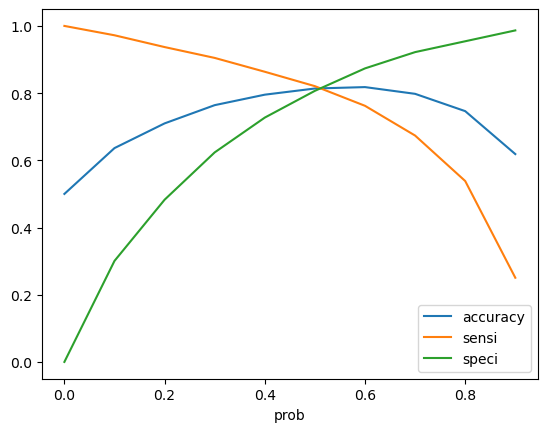

In [363]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

#### From the curve above, 0.3 is the optimum point to take it as a cutoff probability.

In [376]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.6 else 0)

y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.299163,99505,0,1,1,1,0,0,0,0,0,0,0,0
1,0,0.381667,65389,0,1,1,1,1,0,0,0,0,0,0,0
2,0,0.610535,48250,1,1,1,1,1,1,1,1,0,0,0,1
3,0,0.298333,15446,0,1,1,1,0,0,0,0,0,0,0,0
4,0,0.442366,68783,0,1,1,1,1,1,0,0,0,0,0,0


In [377]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted)

0.8179287305122495

In [378]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.final_predicted )
confusion2

array([[1569,  227],
       [ 427, 1369]], dtype=int64)

In [379]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [380]:
print("Train Set:")

# Sensitivity
print("Sensitivity:-",TP_train / float(TP_train+FN_train))

# Specificity
print("Specificity:-", TN_train / float(TN_train+FP_train))


Train Set:
Sensitivity:- 0.8307349665924276
Specificity:- 0.8964365256124721


In [381]:
# Adding constant
X_test_rfe = sm.add_constant(X_test_rfe)

In [382]:
# Predict on the test set
y_test_pred = result_logm1.predict(X_test_rfe)

In [383]:
TP_test = confusion_test[1,1] # true positive 
TN_test = confusion_test[0,0] # true negatives
FP_test = confusion_test[0,1] # false positives
FN_test = confusion_test[1,0] # false negatives

In [384]:
print("Test Set:")

# Sensitivity
print("Sensitivity:-",TP_test / float(TP_test+FN_test))

# Specificity
print("Specificity:-", TN_test / float(TN_test+FP_test))

Test Set:
Sensitivity:- 0.8143036386449184
Specificity:- 0.8826870832304272


Final conclusion with no PCA

We can see that the logistic model with no PCA has good sensitivity, and is comparable to the models with PCA. So, we can go for a more simplistic model such as logistic regression without PCA as it explains the important predictor variables as well as the significance of each variable. 

The model also hels us to identify the variables which should be act upon for making the decision of the to be churned customers. 
Hence, the model is more relevant in terms of explaining to the business.